In [1]:
import nest
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import List, Dict, Any
from IPython.display import Image, display
from numpy import diag, array, zeros 
import random
import numpy as np
import numpy as np, heapq, random
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from neuron_toolbox import *
from dataclasses import dataclass, asdict
import json
import copy
import random
from typing import List, Tuple, Callable, Optional, Dict, Any



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.9.0-post0.dev0
 Built: Nov  5 2025 22:40:13

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
SCALING_FACTOR = 1.0
k= 10.0
m= np.zeros(3)
dt = 0.01
positions=[np.zeros(3)]
gsl = 8

In [3]:
area2models = {
    
    "V1": ["iaf_cond_alpha","aeif_cond_alpha","iaf_cond_exp","hh_psc_alpha","iaf_cond_alpha","iaf_cond_beta_gap"],
    
    "V2": ["aeif_cond_alpha","iaf_cond_exp","aeif_cond_alpha","hh_psc_alpha","iaf_cond_alpha"],
    
    "V3": ["aeif_cond_alpha","iaf_cond_exp","aeif_cond_alpha","hh_psc_alpha","iaf_cond_alpha"], 
    
    "V4": ["aeif_cond_alpha","iaf_cond_exp","hh_psc_alpha","gif_cond_exp","iaf_cond_alpha","iaf_cond_beta_gap"],
    
    "V5": ["iaf_cond_alpha","aeif_cond_alpha","hh_psc_alpha","izhikevich","iaf_cond_beta_gap"],
    
    "V6": ["iaf_cond_alpha","aeif_cond_alpha","hh_psc_alpha","iaf_psc_delta","iaf_cond_alpha","iaf_cond_beta_gap"]
    
}

In [4]:
### Helper functions

def extract_connections(pre, post):

    conn = nest.GetConnections(pre, post)
    df = pd.DataFrame({
        "pre_gid":  conn.source,
        "post_gid": conn.target,
        "weight":   nest.GetStatus(conn, "weight"),
        "delay":    nest.GetStatus(conn, "delay")
    })
    return df


def to_adjacency(df, pre_ids, post_ids, attr="weight"):
    idx = {gid: i for i, gid in enumerate(pre_ids)}
    jdx = {gid: j for j, gid in enumerate(post_ids)}
    mat = np.zeros((len(pre_ids), len(post_ids)))
    for _, row in df.iterrows():
        i, j = idx[row.pre_gid], jdx[row.post_gid]
        mat[i, j] = row[attr]
    return mat


def plot_point_clusters(
    clusters,
    colors= None,
    marker_size = 20,
    cmap = 'tab10',
    xlabel = 'X',
    ylabel = 'Y',
    zlabel = 'Z',
    title = None,
    edgecolor='k', alpha=0.8,linewidths=1.5
):
    """
    Plots multiple 3D point clouds in distinct colors.

    Args:
        clusters (List[np.ndarray]): 
            List of arrays, each of shape (N_i, 3), containing (x,y,z) points.
        colors (List[str], optional):
            List of colors (matplotlib format) to use for each cluster. 
            If None, a categorical colormap is used.
        marker_size (float, optional):
            Size of scatter markers.
        cmap (str, optional):
            Name of categorical colormap (used if colors is None).
        xlabel, ylabel, zlabel (str, optional):
            Axis labels.
        title (str, optional):
            Plot title.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    n = len(clusters)
    
    if colors is None:
        cmap_obj = plt.get_cmap(cmap)
        colors = [cmap_obj(i / max(n-1, 1)) for i in range(n)]
    
    for pts, col in zip(clusters, colors):
        pts = np.asarray(pts)
        if pts.size == 0:
            continue
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                   c=[col], s=marker_size, edgecolor=edgecolor, alpha=alpha,linewidths=linewidths)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    if title:
        ax.set_title(title)
    plt.show()
    

def plot_point_clusters_normalized(
        clusters,
        colors=None,
        marker_size=20,
        cmap='tab10',
        xlabel='X', ylabel='Y', zlabel='Z',
        title=None,
        edgecolor='k', alpha=0.8, linewidths=1.5):

    fig = plt.figure()
    ax  = fig.add_subplot(111, projection='3d')

    n = len(clusters)
    if colors is None:
        cmap_obj = plt.get_cmap(cmap)
        colors = [cmap_obj(i / max(n - 1, 1)) for i in range(n)]

    mins = np.full(3,  np.inf)
    maxs = np.full(3, -np.inf)

    for pts, col in zip(clusters, colors):
        pts = np.asarray(pts)
        if pts.size == 0:
            continue
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                   c=[col], s=marker_size,
                   edgecolor=edgecolor, alpha=alpha, linewidths=linewidths)

        mins = np.minimum(mins, pts.min(axis=0))
        maxs = np.maximum(maxs, pts.max(axis=0))

    span   = max(maxs - mins)
    centre = (maxs + mins) / 2

    ax.set_xlim(centre[0] - span / 2, centre[0] + span / 2)
    ax.set_ylim(centre[1] - span / 2, centre[1] + span / 2)
    ax.set_zlim(centre[2] - span / 2, centre[2] + span / 2)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    if title:
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

# may be usefull later, I dunno.
def set_axes_equal(ax):
        #~*~*~*~* START  *~*~*~*~#

    """
    Adjust a 3D Matplotlib axis so that the X, Y and Z axes are scaled equally.

    This avoids distortion in 3D plots by ensuring that one unit in X, Y, and Z
    appear the same length on screen.

    Args:
        ax (mpl_toolkits.mplot3d.axes3d.Axes3D): The 3D axes to adjust.
    """
        #~*~*~*~* END  *~*~*~*~#

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()
    x_range = x_limits[1] - x_limits[0]
    y_range = y_limits[1] - y_limits[0]
    z_range = z_limits[1] - z_limits[0]
    max_range = max(x_range, y_range, z_range)
    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)
    ax.set_xlim3d(x_middle - max_range/2, x_middle + max_range/2)
    ax.set_ylim3d(y_middle - max_range/2, y_middle + max_range/2)
    ax.set_zlim3d(z_middle - max_range/2, z_middle + max_range/2)


    
def make_div_curl(f1, f2, f3, h = 1e-5):

    def div(x, y, z):
        df1dx = (f1(x + h, y, z) - f1(x - h, y, z)) / (2*h)
        df2dy = (f2(x, y + h, z) - f2(x, y - h, z)) / (2*h)
        df3dz = (f3(x, y, z + h) - f3(x, y, z - h)) / (2*h)
        return df1dx + df2dy + df3dz

    def curl(x, y, z):
        df3dy = (f3(x, y + h, z) - f3(x, y - h, z)) / (2*h)
        df2dz = (f2(x, y, z + h) - f2(x, y, z - h)) / (2*h)
        c1 = df3dy - df2dz

        df1dz = (f1(x, y, z + h) - f1(x, y, z - h)) / (2*h)
        df3dx = (f3(x + h, y, z) - f3(x - h, y, z)) / (2*h)
        c2 = df1dz - df3dx

        df2dx = (f2(x + h, y, z) - f2(x - h, y, z)) / (2*h)
        df1dy = (f1(x, y + h, z) - f1(x, y - h, z)) / (2*h)
        c3 = df2dx - df1dy

        return np.array([c1, c2, c3])

    return div, curl


In [5]:
def generate_direction_similarity_matrix(
    pop1=None,
    pop2=None,
    vecfield1=(
        lambda x, y, z: 1.5 * x ** 2 + y + z,
        lambda x, y, z: 1.3 * x ** 3 - y + z,
        lambda x, y, z: 1.7 * x ** 2 + y - z,
    ),
    vecfield2=(
        lambda x, y, z: 4.7 * x - np.sin(y),
        lambda x, y, z: -1.9 * x ** 2 - y + 2,
        lambda x, y, z: 1.7 * y ** 2 + x - y,
    ),
    eps: float = 1e-12,
    plot: bool = False,
    cmap: str = "plasma",
    arrow_length: float = 0.2,
):
    """
    Compute a cosine-similarity weight matrix W between two 3-D vector fields.
    The fields are evaluated on point clouds *pop1* (sources) and *pop2*
    (targets).  If either population is *None*, a default 4 × 4 × 4 grid is
    generated and transformed with hard-coded parameters.

    Parameters
    ----------
    pop1, pop2 : np.ndarray | None
        Arrays with shape (N, 3) and (M, 3) giving the coordinates of the
        source and target neurons.  When *None*, a default grid is built via
        ``generate_cube`` and ``transform_points`` (see example).
    vecfield1, vecfield2 : tuple(callable, callable, callable)
        Component functions (f₁, f₂, f₃) mapping (x, y, z) → ℝ for each field.
    eps : float
        Floor for vector norms to avoid division by zero.
    plot : bool
        Forwarded to ``field`` to display 3-D quiver plots.
    cmap : str
        Matplotlib colour map used when *plot=True*.
    arrow_length : float
        Arrow scale in the quiver plots.

    Returns
    -------
    numpy.ndarray
        Weight matrix W with shape (len(pop2), len(pop1)); entries are cosine
        similarities in [-1, 1].

    Example
    -------
    >>> W = generate_direction_similarity_matrix()        # defaults
    >>> nest.Connect(pop1_nodes, pop2_nodes,
    ...              syn_spec={'weight': W.astype(np.float32)})
    """
    # ---------------------------------------------------------------------
    if pop1 is None:
        grid = generate_cube((4, 4, 4))
        pop1 = transform_points(
            grid, [1, 2, 3], 120, 120, transform_matrix=np.eye(3), plot=plot
        )
    if pop2 is None:
        grid = generate_cube((4, 4, 4))
        pop2 = transform_points(
            grid, [3, 3, 1], 24, 77, transform_matrix=np.eye(3), plot=plot
        )

    f1v1, f2v1, f3v1 = vecfield1
    f1v2, f2v2, f3v2 = vecfield2

    vec1 = field(pop1, plot=plot, normalize=True, cmap=cmap,
                 arrow_length=arrow_length, f1=f1v1, f2=f2v1, f3=f3v1)
    vec2 = field(pop2, plot=plot, normalize=True, cmap=cmap,
                 arrow_length=arrow_length, f1=f1v2, f2=f2v2, f3=f3v2)

    u1 = vec1 / np.clip(np.linalg.norm(vec1, axis=1, keepdims=True), eps, None)
    u2 = vec2 / np.clip(np.linalg.norm(vec2, axis=1, keepdims=True), eps, None)

    return u2 @ u1.T


def generate_direction_similarity_matrix2(
    grid_shape=(4, 4, 4),
    transform1=None,
    transform2=None,
    stretch1=(1, 1, 1),
    stretch2=(1, 1, 1),
    vecfield1=(
        lambda x, y, z: 1.5 * x ** 2 + y + z,
        lambda x, y, z: 1.3 * x ** 3 - y + z,
        lambda x, y, z: 1.7 * x ** 2 + y - z,
    ),
    vecfield2=(
        lambda x, y, z: 4.7 * x - np.sin(y),
        lambda x, y, z: -1.9 * x ** 2 - y + 2,
        lambda x, y, z: 1.7 * y ** 2 + x - y,
    ),
    eps=1e-12,
    plot=False,
    cmap="plasma",
    arrow_length=0.2,
):
    """
    Generate a cosine-similarity weight matrix between two 3-D vector fields
    evaluated on two separately transformed point grids.  See full docstring
    below for details.
    """
    if transform1 is None:
        transform1 = dict(m=[1, 2, 3], rot_theta=120, rot_phi=120)
    if transform2 is None:
        transform2 = dict(m=[3, 3, 1], rot_theta=24, rot_phi=77)

    grid = generate_cube(grid_shape)                       
    pop1 = transform_points(
        grid,
        transform1["m"],
        transform1["rot_theta"],
        transform1["rot_phi"],
        transform_matrix=np.diag(stretch1),
        plot=plot,
    )
    pop2 = transform_points(
        grid,
        transform2["m"],
        transform2["rot_theta"],
        transform2["rot_phi"],
        transform_matrix=np.diag(stretch2),
        plot=plot,
    )

    f1v1, f2v1, f3v1 = vecfield1
    f1v2, f2v2, f3v2 = vecfield2

    vec1 = field(pop1, plot=plot, normalize=True, cmap=cmap,
                 arrow_length=arrow_length, f1=f1v1, f2=f2v1, f3=f3v1)
    vec2 = field(pop2, plot=plot, normalize=True, cmap=cmap,
                 arrow_length=arrow_length, f1=f1v2, f2=f2v2, f3=f3v2)

    u1 = vec1 / np.clip(np.linalg.norm(vec1, axis=1, keepdims=True), eps, None)
    u2 = vec2 / np.clip(np.linalg.norm(vec2, axis=1, keepdims=True), eps, None)

    return u2 @ u1.T


In [6]:

class PolynomGenerator:
    def __init__(self, n=5, decay=0.5, coefficients=None):
        self.n = n # max power of term is x^n,y^n,z^n
        self.terms = self.term_matrix()#in every func_gen there is a matrix full of power-terms which'll be chosen from when constructing the polynomial
        self.coefficients = self.random_coefficients() if coefficients is None else coefficients#chosen coefficients for each term
        self.decay = decay#if random, this decides how quickly coefficients for higher powers decay with each +1 in exponent
        self.term_power_probability = self.create_exponential_prob_vector(n=n+1, decay=decay)#how likely it is to pick specific powers
    
    @property
    def coefficients(self):
        return self._coefficients
    
    @coefficients.setter
    def coefficients(self, value):
        if not isinstance(value, np.ndarray):
            raise TypeError("")
        if value.shape != (self.n + 1, 3):
            raise ValueError("")
        self._coefficients = value
    
    def term_matrix(self):
        matrix = []
        for power in range(self.n + 1):
            if power == 0:
                row = [
                    lambda x, y, z: 1.0,
                    lambda x, y, z: 1.0,
                    lambda x, y, z: 1.0
                ]
            else:
                row = [
                    lambda x, y, z, p=power: x ** p,
                    lambda x, y, z, p=power: y ** p,
                    lambda x, y, z, p=power: z ** p
                ]
            matrix.append(row)
        
        return np.array(matrix, dtype=object)
    
    def random_coefficients(self):
        return np.random.randn(self.n + 1, 3) 
        
    def create_exponential_prob_vector(self, n, decay):
        probs = np.exp(-decay * np.arange(n))
        probs = probs / probs.sum()
        return probs

    def generate(self, num_terms, safe_mode=True, max_power=2, max_coeff=0.5, clip_output=True):
        """
        Generate polynomial with optional safety features to prevent overflow
        
        Args:
            num_terms: Number of terms in polynomial
            safe_mode: If True, applies safety constraints (recommended)
            max_power: Maximum power for terms (0-max_power), lower = safer
            max_coeff: Maximum absolute coefficient value
            clip_output: If True, clips final output to prevent extreme values
        
        Returns:
            final_polynom: Callable polynomial function
            index_list: List of [idx, jdx] indices
            coefficients: List of coefficient values
        """
        polynom_terms = []
        index_list = []
        coefficients = []
        
        for i in range(num_terms):
            if np.random.rand() < 0.8 or len(polynom_terms) == 0:
                idx = np.random.choice([0, 1, 2])
                
                if safe_mode:
                    # Limit power to prevent overflow
                    safe_powers = [p for p in range(min(max_power + 1, len(self.terms)))]
                    # Adjust probabilities for lower powers
                    safe_probs = self.term_power_probability[:len(safe_powers)]
                    safe_probs = safe_probs / safe_probs.sum()  # Renormalize
                    jdx = np.random.choice(safe_powers, p=safe_probs)
                else:
                    jdx = np.random.choice(len(self.terms), p=self.term_power_probability)
                
                term = self.terms[jdx][idx]
                coeff = self.coefficients[jdx][idx]
                
                if safe_mode:
                    # Clip coefficient to safe range
                    coeff = np.clip(coeff, -max_coeff, max_coeff)
                
                coefficients.append(coeff)
                index_list.append([idx, jdx])
                polynom_terms.append(lambda x, y, z, t=term, c=coeff: c * t(x, y, z))
        
        def final_polynom(x, y, z):
            """Safe polynomial evaluation with overflow protection"""
            if isinstance(x, np.ndarray):
                result = np.zeros_like(x, dtype=float)
            else:
                result = 0.0
            
            # Evaluate each term with error handling
            for term_func in polynom_terms:
                try:
                    with np.errstate(over='raise', invalid='raise'):
                        term_result = term_func(x, y, z)
                except (FloatingPointError, RuntimeWarning):
                    # On overflow, skip this term
                    continue
                
                # Replace NaN/Inf before adding
                term_result = np.nan_to_num(term_result, nan=0.0, 
                                           posinf=100.0, neginf=-100.0)
                result += term_result
            
            # Final safety: replace any NaN/Inf in result
            result = np.nan_to_num(result, nan=0.0, posinf=100.0, neginf=-100.0)
            
            if clip_output and safe_mode:
                # Clip final output to reasonable range
                result = np.clip(result, -100.0, 100.0)
            
            return result
        
        return final_polynom, index_list, coefficients
    
    
    def reconstruct(self, index_list, coefficients):
        polynom_terms = []
       
        for (idx, jdx), coeff in zip(index_list, coefficients):
            term = self.terms[jdx][idx]
            polynom_terms.append(lambda x, y, z, t=term, c=coeff: c * t(x, y, z))
       
        def final_polynom(x, y, z):
            if isinstance(x, np.ndarray):
                result = np.zeros_like(x, dtype=float)
            else:
                result = 0.0
           
            for term_func in polynom_terms:
                result += term_func(x, y, z)
            return result
       
        return final_polynom

    def reconstruct_from_list(self, indices_list, coefficients_list):
        polynoms = []
    
        for index_list, coefficient_list in zip(indices_list, coefficients_list):
            poly = self.reconstruct(index_list, coefficient_list)
            polynoms.append(poly)
    
        return polynoms
    
    def generate_multiple(self, n_polynoms, num_terms, safe_mode=True, max_power=2, max_coeff=0.5):
        """
        Generate multiple safe polynomials
        
        Args:
            n_polynoms: Number of polynomials to generate
            num_terms: Terms per polynomial
            safe_mode: Enable safety features
            max_power: Maximum power for terms
            max_coeff: Maximum coefficient magnitude
        
        Returns:
            polynoms: List of polynomial functions
            indices: List of index lists
            coeffs: List of coefficient lists
        """
        polynoms = []
        indices = []
        coeffs = []
    
        for _ in range(n_polynoms):
            poly, index_list, coefficient_list = self.generate(
                num_terms, 
                safe_mode=safe_mode,
                max_power=max_power,
                max_coeff=max_coeff
            )
            polynoms.append(poly)
            indices.append(index_list)
            coeffs.append(coefficient_list)
    
        return polynoms, indices, coeffs
    
    def decode_polynom(self, encoded_polynom):

        index_list = encoded_polynom['indices']
        coefficient_list = encoded_polynom['coefficients']
        
        return self.reconstruct(index_list, coefficient_list)
    
    def encode_multiple(self, indices_list, coefficients_list):
        encoded_polynoms = []
        for idx_list, coeff_list in zip(indices_list, coefficients_list):
            encoded = self.encode_polynom(idx_list, coeff_list)
            encoded_polynoms.append(encoded)
        return encoded_polynoms
    
    def decode_multiple(self, encoded_polynoms):
        polynoms = []
        for encoded in encoded_polynoms:
            poly = self.decode_polynom(encoded)
            polynoms.append(poly)
        return polynoms

    def derivative(self, encoded_polynom, variable='x'):
        index_list = encoded_polynom['indices']
        coefficient_list = encoded_polynom['coefficients']
        
        var_map = {'x': 0, 'y': 1, 'z': 2}
        target_idx = var_map[variable]
        
        deriv_terms = []
        
        for (idx, jdx), coeff in zip(index_list, coefficient_list):
            if idx != target_idx:
                continue
            power = jdx
            
            if power == 0:
                continue
            
            new_coeff = coeff * power
            new_power = power - 1
            
            deriv_terms.append({
                'idx': idx,
                'jdx': new_power,
                'coeff': new_coeff
            })
        
        # Baue finale Funktion
        def derivative_polynom(x, y, z):
            if isinstance(x, np.ndarray):
                result = np.zeros_like(x, dtype=float)
            else:
                result = 0.0
            
            for term_info in deriv_terms:
                idx = term_info['idx']
                jdx = term_info['jdx']
                coeff = term_info['coeff']
                
                # Hole Term aus term_matrix
                term = self.terms[jdx][idx]
                
                # Evaluiere
                result += coeff * term(x, y, z)
            
            return result
        
        return derivative_polynom

    def gradient(self, encoded_polynom):

        df_dx = self.derivative(encoded_polynom, variable='x')
        df_dy = self.derivative(encoded_polynom, variable='y')
        df_dz = self.derivative(encoded_polynom, variable='z')
        
        return df_dx, df_dy, df_dz
    
    
    def gradient_vector(self, encoded_polynom, x, y, z):

        df_dx, df_dy, df_dz = self.gradient(encoded_polynom)
        
        grad = np.array([
            df_dx(x, y, z),
            df_dy(x, y, z),
            df_dz(x, y, z)
        ])
        
        return grad
    def derivative_encoded(self, encoded_polynom, variable='x'):

        index_list = encoded_polynom['indices']
        coefficient_list = encoded_polynom['coefficients']
        
        var_map = {'x': 0, 'y': 1, 'z': 2}
        target_idx = var_map[variable]
        
        new_indices = []
        new_coeffs = []
        
        for (idx, jdx), coeff in zip(index_list, coefficient_list):
            if idx != target_idx or jdx == 0:
                continue
            
            power = jdx
            new_coeff = coeff * power
            new_power = power - 1
            
            new_indices.append([idx, new_power])
            new_coeffs.append(new_coeff)
        
        return {
            'indices': new_indices,
            'coefficients': new_coeffs,
            'n': self.n,
            'decay': self.decay
        }
    
    
    def second_derivative(self, encoded_polynom, var1='x', var2='x'):

        first_deriv_encoded = self.derivative_encoded(encoded_polynom, variable=var1)
        
        second_deriv = self.derivative(first_deriv_encoded, variable=var2)
        
        return second_deriv

# Geometric Functions

In [7]:
def circle3d(
    n=10, 
    r=1.0, 
    theta=0, 
    phi=0, 
    m=(0,0,0), 
    name="Circle", 
    plot=False
    ):
    """
    Generate points on a rotated and translated 3D circle.

    Args:
        n (int): Number of points to sample along the circle.
        r (float): Radius of the circle.
        theta (float): Rotation angle around the X-axis, in degrees.
        phi (float):   Rotation angle around the Y-axis, in degrees.
        m (tuple):     3-tuple giving the translation offset (x, y, z).
        name (str):    Title for the plot if `plot=True`.

    Returns:
        np.ndarray: Array of shape (n, 3) containing the (x, y, z) coordinates.
    """

    
    X_angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    x_coords = SCALING_FACTOR * r * np.cos(X_angles)
    y_coords = SCALING_FACTOR * r * np.sin(X_angles)
    z_coords = np.zeros(n)

    theta = np.deg2rad(theta)
    phi   = np.deg2rad(phi)
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(theta), -np.sin(theta)],
                   [0, np.sin(theta),  np.cos(theta)]])
    Ry = np.array([[ np.cos(phi), 0, np.sin(phi)],
                   [0,           1, 0         ],
                   [-np.sin(phi),0, np.cos(phi)]])
    rotM = Ry @ Rx

    pts = np.vstack((x_coords, y_coords, z_coords)).T
    pts = pts @ rotM
    pts = pts + np.array(m)

    if plot:
        fig = plt.figure()
        ax  = fig.add_subplot(111, projection='3d')
        ax.plot(pts[:,0], pts[:,1], pts[:,2], lw=2)
        max_val = np.max(np.abs(pts))
        ax.set_xlim(-max_val*1.2, max_val*1.2)
        ax.set_ylim(-max_val*1.2, max_val*1.2)
        ax.set_zlim(-max_val*1.2, max_val*1.2)
        ax.set_title(name)
        ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
        plt.show()

    return pts

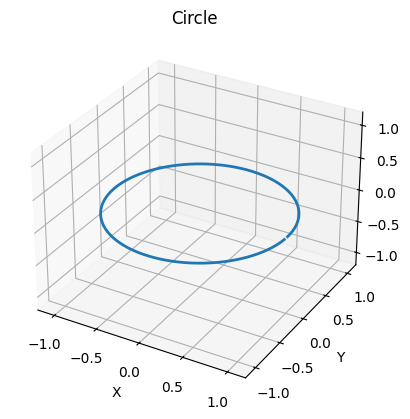

In [8]:
circle_points = circle3d(n=100,plot=True)

In [9]:
def create_cone(
    m=np.zeros(3, dtype=np.float32),
    n=1500,
    inner_radius=0.1,
    outer_radius=0.2,
    height=0.6,
    rot_theta=0.0,
    rot_phi=0.0,
    plot=False,
    name="Cone"
    ):
    #~*~*~*~* START *~*~*~*~#
    """
    Generate random points within a truncated cone, apply rotation and translation.

    Args:
        m (np.ndarray): 3-element center offset (x, y, z) of the cone base.
        n (int): Number of points to generate.
        inner_radius (float): Radius of the top (smaller) circle.
        outer_radius (float): Radius of the bottom (larger) circle.
        height (float): Vertical height of the cone.
        rot_theta (float): Rotation angle around the X-axis in degrees.
        rot_phi (float): Rotation angle around the Y-axis in degrees.
        plot (bool): If True, display a 3D scatter plot of generated points.

    Returns:
        np.ndarray: Array of shape (n, 3) containing the (x, y, z) coordinates of points.
    """
    
    #~*~*~*~* END *~*~*~*~#
    

    inner_r = inner_radius * SCALING_FACTOR  
    outer_r = outer_radius * SCALING_FACTOR
    h = height * SCALING_FACTOR
    
    ang = np.random.uniform(0, 2*np.pi, n)
    z = np.random.uniform(m[2], m[2] + h, n)
    
    r = inner_r + (outer_r - inner_r) * ((z - m[2]) / h)
    
    x = m[0] + r * np.cos(ang)
    y = m[1] + r * np.sin(ang)
    
    # randomized on the surface.
    th = np.deg2rad(rot_theta)
    ph = np.deg2rad(rot_phi)
    
    Rx = np.array([[1,         0,          0       ],
                   [0, np.cos(th), -np.sin(th)],
                   [0, np.sin(th),  np.cos(th)]])
    Ry = np.array([[ np.cos(ph), 0, np.sin(ph)],
                   [          0, 1,          0],
                   [-np.sin(ph), 0, np.cos(ph)]])
    rotM = Ry @ Rx
    
    points = np.column_stack((x, y, z))
    points = points @ rotM.T
    
    if plot:
        from mpl_toolkits.mplot3d import Axes3D 
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:,0], points[:,1], points[:,2], s=2)
        ax.set(title=name)
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')
        plt.show()
    
    return points

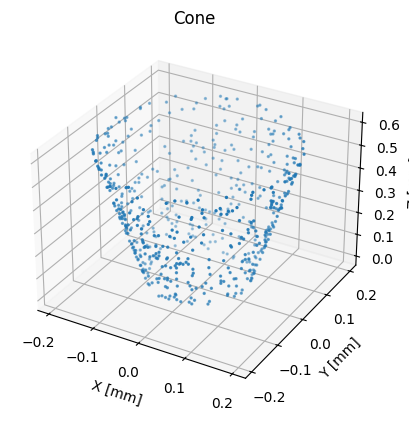

In [10]:
cone_points = create_cone(n=600,plot=True)

In [11]:
def blob_positions(
    n = 10,
    m = np.zeros(3),
    r = 1.0,
    scaling_factor = 1.0,
    plot=False,
    name="Blob"
    ):


    pos_norm = np.random.normal(size=(n, 3))
    pos_norm /= np.linalg.norm(pos_norm, axis=1, keepdims=True)
    
    u = np.random.rand(n, 1)
    r_scaling = r * u**(1/3)
    
    pts = m + pos_norm * r_scaling * scaling_factor

    if plot:
        fig = plt.figure()
        ax  = fig.add_subplot(111, projection='3d')

        ax.scatter(pts[:,0], pts[:,1], pts[:,2])

        lim = 1.1*np.abs(pts).max()
        ax.set(xlim=(-lim, lim), ylim=(-lim, lim), zlim=(-lim, lim),
               title=name, xlabel='X', ylabel='Y', zlabel='Z')
        plt.show()
    return pts

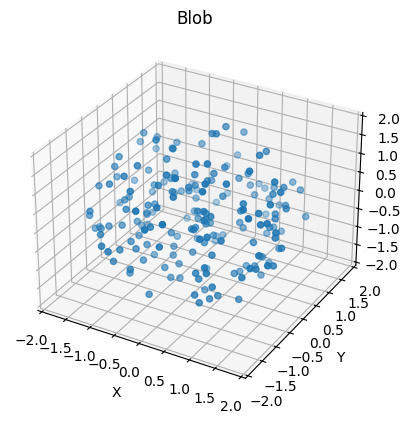

In [12]:
blob_points = blob_positions(n=200,r=2,plot=True)

In [13]:
def create_Grid(m=np.zeros(3, dtype=np.float32),
                grid_size_list=[28, 15, 10],
                rot_theta=0.0, 
                rot_phi=0.0, 
                plot=False,
               name="Grid"):
        #~*~*~*~* START  *~*~*~*~#

    """
    Generate a stack of 2D grid layers in 3D space and optionally plot them.

    Each layer is a k×k grid of points lying in a plane at increasing offsets
    along the first coordinate. The entire stack is then rotated and translated.

    Args:
        m (np.ndarray):       3-vector translation offset applied after rotation.
        grid_size_list (list): List of integers [d1, d2, d3,...], where each
                               entry di defines the grid resolution (di×di)
                               for the layer at depth index i.
        rot_theta (float):    Rotation angle around the X-axis in degrees.
        rot_phi (float):      Rotation angle around the Y-axis in degrees.
        plot (bool):          If True, display a 3D scatter of all layers.

    Returns:
        list of np.ndarray:   A list where each element is an (di*di, 3) array
                              of 3D coordinates for layer i.
    """
        #~*~*~*~* END  *~*~*~*~#

    
    th = np.deg2rad(rot_theta)
    ph = np.deg2rad(rot_phi)
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(th), -np.sin(th)],
                   [0, np.sin(th),  np.cos(th)]])
    Ry = np.array([[ np.cos(ph), 0, np.sin(ph)],
                   [          0, 1,          0],
                   [-np.sin(ph), 0, np.cos(ph)]])
    rotM = Ry @ Rx

    node_layers = []
    for d, k in enumerate(grid_size_list):
        pts = np.array([[d + m[0], w + m[1], n + m[2]]
                        for w in range(k) for n in range(k)])
        node_layers.append(pts @ rotM.T)

    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for layer_pts in node_layers:
            ax.scatter(layer_pts[:, 0], layer_pts[:, 1], layer_pts[:, 2], s=1)
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')
        ax.set(title=name)
        try:
            ax.set_box_aspect((1,1,1))
        except AttributeError:
            set_axes_equal(ax)
        plt.show()

    return node_layers

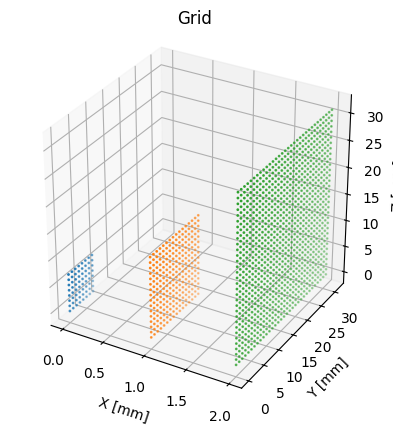

In [14]:
flat_grids = create_Grid(grid_size_list=[gsl,gsl*2,gsl*4],plot=True)

In [15]:
def wave_collapse_old(mask=None, 
                  dims=(2,2,2), 
                  sparse_holes = 0,
                  type_array=[0,1],
                  probability_vector=np.array([0.3,0.7]), 
                  start_pos=np.zeros(3),
                  sparsity_factor=0.7,
                seed=42):
    
    """
    Perform a 3D "wave function collapse" to assign discrete labels to grid cells, 
    forming clusters based on local entropy and neighbor constraints.

    Parameters:
        mask (np.ndarray or None): Initial occupancy mask of shape dims. 
            0 = uncollapsed, -1 = blocked. If None, a zero mask is created.
        dims (tuple[int]): Grid dimensions if mask is None.
        sparse_holes (int): Number of random positions to block (-1) for holes.
        type_array (list[int]): List of possible labels.
        probability_vector (np.ndarray): Initial probability for each label.
        start_pos (array-like): Starting coordinate to seed collapse.
        sparsity_factor (float): Controls influence of existing neighbor labels.
        seed (int): Base seed for random number generators.

    Returns:
        np.ndarray: Array of shape dims with assigned labels for each cell.
    """
    
    
    
    # Initialize random seeds for reproducibility
    random.seed(seed+3)
    np.random.seed(seed+7)

    # Normalize probability vector
    probability_vector = np.asarray(probability_vector, dtype=float)
    probability_vector /= probability_vector.sum()
    
    # Create mask if not provided: 0=uncollapsed, -1=blocked
    if mask is None:
        mask = np.zeros(dims, dtype=np.int32)
    dims=mask.shape
    
    # High initial entropy for all cells
    entropy_matrix = np.full(shape=dims, fill_value=1000.0, dtype=np.float32)
    
    # Store collapsed labels; -1 indicates not yet collapsed
    collapsed_nodes = np.full(shape=dims, fill_value=-1, dtype=np.int32)
    
    
    D0, D1, D2 = mask.shape
    
    
    # Randomly block positions to create holes if desired
    if(sparse_holes!=0):
        for _ in range(0,sparse_holes,1):
            x = random.randint(0,D0-1)
            y = random.randint(0,D1-1)
            z = random.randint(0,D2-1)
            mask[x][y][z] = -1
        
    def check_neighbors(i, j, k):
        undef_neighbors = []
        def_neighbors = []
        """
        Return lists of uncollapsed and collapsed neighbor coordinates in all directions.
        """ 
        shifts = [(dx, dy, dz)         # Examine all 26 neighbors in 3D
              for dx in (-1, 0, 1) 
              for dy in (-1, 0, 1) 
              for dz in (-1, 0, 1) 
              if not (dx == dy == dz == 0)]        
        for di, dj, dk in shifts:
            ni, nj, nk = i+di, j+dj, k+dk
            if 0 <= ni < D0 and 0 <= nj < D1 and 0 <= nk < D2:
                if mask[ni, nj, nk] == 0:
                    undef_neighbors.append((ni, nj, nk))
                elif mask[ni, nj, nk] == 1:
                    def_neighbors.append((ni, nj, nk))
                else:
                    continue  # ignore blocked cells

                    
        return undef_neighbors, def_neighbors
    

    def entropy(p, base=None):
        """Compute Shannon entropy of probability vector p."""
        p = np.asarray(p, dtype=float)
        p += 0.0001
        p/=np.sum(p)# p > 0
        log_p = np.log(p) if base is None else np.log(p) / np.log(base)
        return -np.sum(p * log_p)
    
    def collapse(i, j, k):        
        """
        Collapse the cell at (i,j,k) by sampling a label based on local probabilities and neighbor influence.
        """
        if(mask[i][j][k]):#if already collapsed
            pass #TODO for invariants
        
        # Copy and adjust probabilities based on collapsed neighbors

        
        l = len(probability_vector)
        l1 = int((1-sparsity_factor)*l) 
        # Boost probability for each neighbor label

        list_of_uncollapsed_neighbors, list_of_collapsed_neighbors = check_neighbors(i,j,k)
        
        neighbor_labels = []
        for x,y,z in list_of_collapsed_neighbors:
            neighbor_labels.append(collapsed_nodes[x][y][z])
        
        #possible_values = np.setdiff1d(type_array,neighbor_labels) #regel zu hart für Klusterbildung
        
        private_probability_vector = probability_vector.copy()

        #######################################################################
        original_pv = private_probability_vector.copy()
        #######################################################################
        
        for m in neighbor_labels:# label gleichzeitig index für probability vektor
            # private_probability_vector anpassen
            p = private_probability_vector[m] / (l + l1)
            p_self = l1 * p
            p_rest = p
            p_redistribution = np.full(shape=(l,),fill_value=p_rest)
            p_redistribution[m] += p_self
            private_probability_vector[m] = 0.0 #setze wert im original zurück
            private_probability_vector+=p_redistribution
        private_probability_vector/=private_probability_vector.sum()#danach um sequenziellen Einfluss zu minimieren
        private_probability_vector=(private_probability_vector+2*original_pv)/3############################################
        #print("#######",np.sum(private_probability_vector))#just a check
        choice = np.random.choice(type_array,p=private_probability_vector)#damit kein ablaufmuster entsteht
        collapsed_nodes[i][j][k] = choice
        mask[i][j][k]=1
        entropy_matrix[i][j][k] = 0.0
        # Update entropy for uncollapsed neighbors

        #after collapsed
        # Anpassung der Entropie der Nachbarn

        for ni, nj, nk in list_of_uncollapsed_neighbors:
            _, coll_nbrs = check_neighbors(ni, nj, nk)
            neigh_labels = [collapsed_nodes[x,y,z] for x,y,z in coll_nbrs]

            allowed = np.setdiff1d(type_array, neigh_labels)

            p = np.zeros_like(probability_vector, dtype=float)
            idxs = [type_array.index(a) for a in allowed]
            p[idxs] = probability_vector[idxs]
            if p.sum() > 0:
                p /= p.sum()
            else:
                p[:] = 1 / len(p)
            entropy_matrix[ni, nj, nk] = entropy(p, base=2)
            
            
    def _next():
        """Select the next uncollapsed cell with minimal non-zero entropy."""
        candidates = np.argwhere(mask == 0)
        if candidates.size == 0:
            return None
        valid = [(tuple(idx), entropy_matrix[tuple(idx)]) 
                 for idx in candidates 
                 if entropy_matrix[tuple(idx)] > 0]
        if not valid:
            return None
        next_idx = min(valid, key=lambda x: x[1])[0]
        return next_idx
    
    # Main collapse loop
    while True:
        nxt = _next()
        if nxt is None:
            break
        collapse(*nxt)

    return np.array(collapsed_nodes)#, entropy_matrix

In [16]:
wave_collapse_old(mask=None, 
                  dims=(5,5,5), 
                  sparse_holes = 20,
                  type_array=[0,1,2,3],
                  probability_vector=np.array([0.1,0.2,0.4,0.3]), 
                  start_pos=m,
                  sparsity_factor=0.9)#-1 is empty, everything else is a neuron label

array([[[ 2, -1, -1,  1,  2],
        [ 1,  3,  3,  3,  0],
        [ 2,  2,  3,  3,  2],
        [ 3,  1,  3,  1,  3],
        [-1,  2,  3,  1,  2]],

       [[ 3, -1,  2,  3,  2],
        [ 2,  0,  2,  0,  3],
        [ 0, -1,  1,  1,  2],
        [-1,  2,  2,  1,  0],
        [ 2,  3,  3,  0,  3]],

       [[-1,  3, -1, -1,  0],
        [ 3,  1, -1, -1,  2],
        [ 3,  2, -1,  3,  2],
        [ 2,  1,  1, -1, -1],
        [ 0,  2,  3,  3,  1]],

       [[-1,  1,  0,  2,  2],
        [ 3,  2,  3,  1,  3],
        [ 2,  3,  0,  2,  0],
        [ 2,  1,  2,  0,  2],
        [ 3,  1,  2, -1,  3]],

       [[ 2,  1,  2, -1,  3],
        [ 3,  3,  1,  1,  1],
        [ 2,  2,  3,  3,  2],
        [ 0, -1,  3,  2,  2],
        [ 2,  3, -1,  3,  2]]], dtype=int32)

In [17]:
def wave_collapse(dims, type_array, probability_vector,
                       sparsity_factor=.7, seed=0, sparse_holes=0):
    NEIGHBOR_OFFSETS = np.array([(dx,dy,dz)
      for dx in (-1,0,1) for dy in (-1,0,1) for dz in (-1,0,1)
      if (dx,dy,dz)!=(0,0,0)], dtype=np.int8)
    random.seed(seed+3); np.random.seed(seed+7)
    probability_vector = np.asarray(probability_vector, float); probability_vector /= probability_vector.sum()
    mask  = np.zeros(dims, np.int8)
    if sparse_holes:                       
        idx = np.random.choice(mask.size, sparse_holes, replace=False)
        mask.ravel()[idx] = -1

    collapsed = -np.ones(dims, np.int16)
    H = np.full(dims, 999., np.float32)

    heap = [(H[i,j,k],i,j,k) for i in range(dims[0])
                               for j in range(dims[1])
                               for k in range(dims[2]) if mask[i,j,k]==0]
    heapq.heapify(heap)

    while heap:
        h,i,j,k = heapq.heappop(heap)
        if mask[i,j,k]:                    
            continue

        neigh = NEIGHBOR_OFFSETS + (i,j,k)
        good  = ((neigh[:,0] >= 0) & (neigh[:,0] < dims[0]) &
                 (neigh[:,1] >= 0) & (neigh[:,1] < dims[1]) &
                 (neigh[:,2] >= 0) & (neigh[:,2] < dims[2]))
        neigh = neigh[good]
        labels = collapsed[tuple(neigh.T)]
        labels = labels[labels >= 0]              

        if labels.size:
            counts = np.bincount(labels, minlength=len(type_array))
            boost  = counts * (1-sparsity_factor)/len(type_array)
            p = probability_vector + boost
            p /= p.sum()
        else:
            p = probability_vector

        choice = np.random.choice(type_array, p=p)
        collapsed[i,j,k] = choice
        mask[i,j,k] = 1
        H[i,j,k] = 0.0

        for ni,nj,nk in neigh:
            if mask[ni,nj,nk]==0:
                H[ni,nj,nk] = 1.0  
                heapq.heappush(heap,(H[ni,nj,nk],ni,nj,nk))

    return collapsed


In [18]:
def generate_cube(grid_size_list=(10, 10, 10)):
    """
    Generate a 3D grid of points within a cube from -1 to 1 in each axis.

    Args:
        grid_size_list (tuple of int): Number of samples along each axis (nx, ny, nz).

    Returns:
        np.ndarray: An array of shape (nx*ny*nz, 3) containing the (x, y, z) coordinates.
    """
    nx, ny, nz = grid_size_list
    xs = np.linspace(-1, 1, nx)
    ys = np.linspace(-1, 1, ny)
    zs = np.linspace(-1, 1, nz)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')
    return np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T

In [19]:
cube_points = generate_cube(grid_size_list=(gsl,gsl,gsl))

In [20]:
def transform_points(
    points,
    m = np.zeros(3, dtype=float),#translation
    rot_theta = 0.0,
    rot_phi = 0.0,
    transform_matrix = np.eye(3),
    plot = False
    ):
    """
    Apply rotation, linear transformation, and translation to a set of 3D points.

    Args:
        points (np.ndarray): Array of shape (N,3) containing the original points.
        m (np.ndarray):      Translation offset as a 3-vector.
        rot_theta (float):   Rotation angle around the X-axis in degrees.
        rot_phi (float):     Rotation angle around the Y-axis in degrees.
        transform_matrix (np.ndarray): 3×3 matrix to apply after rotation.
        plot (bool):         If True, display a 3D scatter of the transformed points.

    Returns:
        np.ndarray: Array of shape (N,3) with transformed coordinates.
    """
    pts = np.asarray(points, dtype=float)
    
    th = np.deg2rad(rot_theta)
    ph = np.deg2rad(rot_phi)
    Rx = np.array([[1,          0,           0],
                   [0, np.cos(th), -np.sin(th)],
                   [0, np.sin(th),  np.cos(th)]])
    Ry = np.array([[ np.cos(ph), 0, np.sin(ph)],
                   [          0, 1,          0],
                   [-np.sin(ph), 0, np.cos(ph)]])
    rotM = Ry @ Rx
    
    rotated = (rotM @ pts.T).T
            
    transformed = (transform_matrix @ rotated.T).T
    
    result = transformed + np.asarray(m, dtype=float)
    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(result[:,0], result[:,1], result[:,2], s=2)
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')
        plt.show()
    
    return result

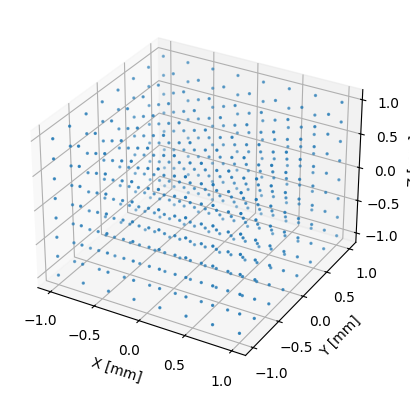

In [21]:
#original
_ = transform_points(cube_points,plot=True)

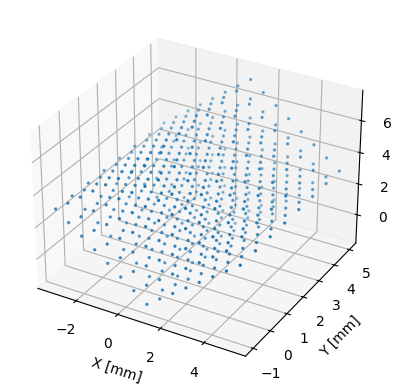

In [22]:
transformed_cube_points = transform_points(cube_points,plot=True,transform_matrix=3.0*np.eye(3),rot_phi=45,m=np.array([1,2,3]))

In [23]:
def field(
        positions: np.ndarray,
        f1 = lambda x, y, z: np.zeros_like(x),
        f2 = lambda x, y, z: np.zeros_like(x),
        f3 = lambda x, y, z: np.zeros_like(x),
        plot=False,    
        normalize = False,
        color_by_length = False,
        cmap = 'viridis',
        arrow_length = 0.1
    ):
    """
    Compute a 3D vector field at given positions and optionally visualize it.

    Args:
        positions (np.ndarray): An (N,3) array of (x,y,z) coordinates.
        f1, f2, f3 (callable):  Functions f1(x,y,z), f2(x,y,z), f3(x,y,z) defining
                                the three vector components at each point.
        plot (bool):           If True, display a 3D quiver plot of the field.
        normalize (bool):      If True, normalize each vector to unit length before plotting.
        color_by_length (bool): If True, color arrows by their original lengths.
        cmap (str):             Name of the Matplotlib colormap to use when coloring.
        arrow_length (float):   Scaling factor for arrow lengths in the plot.

    Returns:
        np.ndarray: An (N,3) array of the computed vectors [v1, v2, v3].
    """
    
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]

    v1 = f1(x, y, z)
    v2 = f2(x, y, z)
    v3 = f3(x, y, z)
    vectors = np.column_stack((v1, v2, v3))
    if plot:
        lengths = np.linalg.norm(vectors, axis=1)
        U, V, W = v1.copy(), v2.copy(), v3.copy()
        if normalize:
            nonzero = lengths > 0
            U[nonzero] /= lengths[nonzero]
            V[nonzero] /= lengths[nonzero]
            W[nonzero] /= lengths[nonzero]
            U *= arrow_length
            V *= arrow_length
            W *= arrow_length
        else:
            U *= arrow_length
            V *= arrow_length
            W *= arrow_length

        color_args = {}
        if color_by_length:
            normed = (lengths - lengths.min()) / (lengths.ptp() if lengths.ptp()>0 else 1)
            cmap_obj = plt.get_cmap(cmap)
            colors = cmap_obj(normed)
            color_args['color'] = colors

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.quiver(
            x, y, z,
            U, V, W,
            **color_args,
            length=1.0,
            normalize=False
        )
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')
        plt.show()
    return vectors


In [24]:
poly_gen = PolynomGenerator(n=3, decay=0.8)

polynoms, indices, coeffs = poly_gen.generate_multiple(
    n_polynoms=3,
    num_terms=4,
    safe_mode=True,
    max_power=2,
    max_coeff=0.5
)
poly1, idx1, coeff1 = poly_gen.generate(num_terms=2, safe_mode=False, max_power=1)
poly2, idx2, coeff2 = poly_gen.generate(num_terms=3, safe_mode=True, max_power=1)
poly3, idx3, coeff3 = poly_gen.generate(num_terms=2, safe_mode=True, max_power=1)

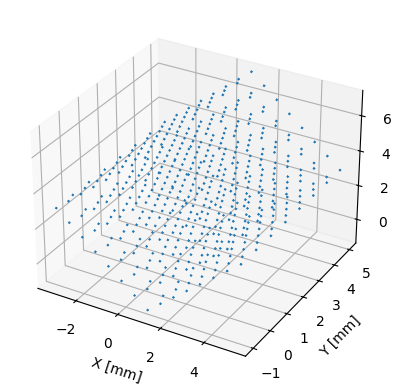

In [25]:
field_vectors_from_positions = field(transformed_cube_points,f1=poly1,f2=poly2,f3=poly3,plot=True,arrow_length=0.3)

In [26]:
def generate_torus(
        R = 1.0,
        r = 0.3,
        grid_size_list = (100, 40),
    rot_theta=0,
    rot_phi=0,
    plot=False
    ):
    """
    Generate a set of 3-D points on the surface of a torus.

    The torus lies in the XY-plane, centred at the origin.  The major
    radius R is the distance from the origin to the centre of the tube,
    the minor radius r is the tube radius.

    Args:
        R (float):            Major radius (distance from origin to tube centre).
        r (float):            Minor radius (tube radius).
        grid_size_list (tuple of int):
                              Number of samples along the two angular
                              coordinates (n_theta, n_phi).  Higher numbers
                              produce a denser point cloud.

    Returns:
        np.ndarray: Array of shape (n_theta * n_phi, 3) with (x, y, z)
                    coordinates on the torus surface.
    """
    n_theta, n_phi = grid_size_list

    
    theta = np.linspace(0.0, 2.0 * np.pi, n_theta, endpoint=False)  
    phi   = np.linspace(0.0, 2.0 * np.pi, n_phi,   endpoint=False)  

    a, b = np.meshgrid(theta, phi, indexing='ij')  

    x = (R + r * np.cos(b)) * np.cos(a)
    y = (R + r * np.cos(b)) * np.sin(a)
    z =  r * np.sin(b)

    return transform_points(np.vstack((x.ravel(), y.ravel(), z.ravel())).T,
                            rot_theta=rot_theta, rot_phi=rot_phi, plot=plot)

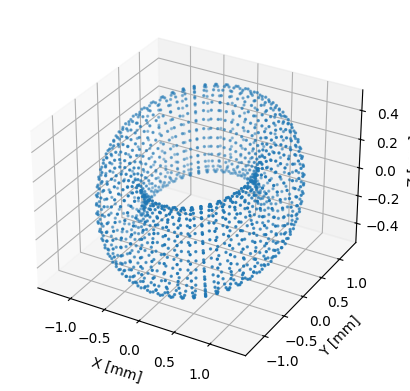

In [27]:
torus_points = generate_torus(grid_size_list=(50,30),plot=True,rot_theta=10)

In [28]:
def simulate_vector_field_flow(
            initial_positions = np.zeros((3,3)),
            dt = 0.001,
            f1 = lambda x, y, z: np.zeros_like(x),
            f2 = lambda x, y, z: np.zeros_like(x),
            f3 = lambda x, y, z: np.zeros_like(x),
            num_steps = 1,
            plot= True,
            scatter_size = 1.0,
            create_object = False #2 Modi, False liefert lediglich die letzte Position, also Endergebnis
                                  # True liefert Liste aller Zwischenschritte
            ):
    """
    Simulate the flow of points through a 3D vector field over multiple time steps.

    Args:
        initial_positions (np.ndarray): Starting positions, shape (N,3).
        dt (float):                    Time step size for Euler integration.
        f1, f2, f3 (callable):         Functions defining the vector field components.
        num_steps (int):               Number of integration steps.
        plot (bool):                   If True, display scatter plots at each step.
        scatter_size (float):          Size of points in the scatter plot.
        create_object (bool):          If True, return a list of all intermediate
                                       position arrays; otherwise return only final positions.

    Returns:
        np.ndarray or List[np.ndarray]:
            Final positions array if create_object=False, otherwise a list of
            position arrays at each time step.
    """
    
    positions = initial_positions.copy()
    snapshots = []
    
    if(create_object):
        snapshots.append(positions)
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    
    for _ in range(num_steps):
        if plot:
            ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=scatter_size)
        velocity = field(positions, f1=f1, f2=f2, f3=f3, plot=False)
        positions = positions + dt * velocity
        if(create_object):
            snapshots.append(positions)

    if plot:
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()
    if(create_object):
        return snapshots
    return positions

def field_flow_iteration(
                        positions=np.zeros(3),  # ← Plural
                        f1 = lambda x, y, z: np.zeros_like(x),
                        f2 = lambda x, y, z: np.zeros_like(x),
                        f3 = lambda x, y, z: np.zeros_like(x)):
    velocity = field(
        positions=positions,
        plot=False,
        f1=f1,
        f2=f2,
        f3=f3
    )
    return positions + dt * velocity

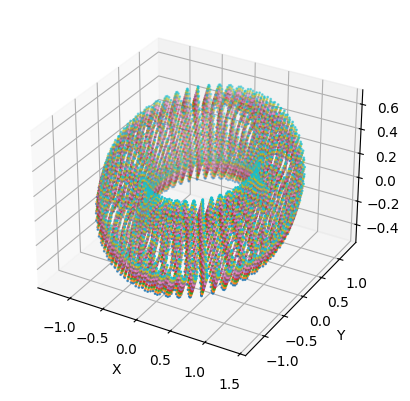

In [29]:
transformed_torus = simulate_vector_field_flow(initial_positions=torus_points,f1=poly1,f2=poly2,f3=poly3,dt=0.05,num_steps=10)

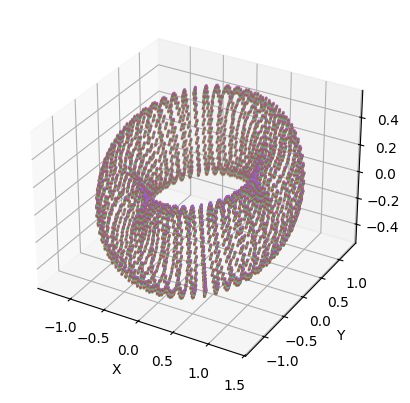

In [30]:
transformed_torus_slow_motion_copy = simulate_vector_field_flow(initial_positions=torus_points,f1=poly1,f2=poly2,f3=poly3,dt=0.01,num_steps=15,create_object=True)

In [31]:
def add_local_attractor(
    m = np.zeros(3),
    k = 15.0,      # Sog-Stärke
    sigma = 0.9,   # Gauß-Breite
    f1 = lambda x, y, z: np.zeros_like(x),
    f2 = lambda x, y, z: np.zeros_like(x),
    f3 = lambda x, y, z: np.zeros_like(x),
    repulsive=False
):
    """
    Adds a local attractor parametrized by the values above. returns a modified version of the original function.
    The influence of attractors decays exponentially with distance. Like this spherical one.
    """
    x0, y0, z0 = m
    s = 1.0 if repulsive else -1.0

    def w(r):
        return s*np.exp(-0.5*(r/sigma)**2)

    def f1_mod(x, y, z):
        dx = x - x0
        r = np.sqrt(dx*dx + (y-y0)**2 + (z-z0)**2)
        sink = -k * s * w(r) * dx
        return f1(x, y, z) + sink

    def f2_mod(x, y, z):
        dy = y - y0
        r = np.sqrt((x-x0)**2 + dy*dy + (z-z0)**2)
        sink = -k * s * w(r) * dy
        return f2(x, y, z) + sink

    def f3_mod(x, y, z):
        dz = z - z0
        r = np.sqrt((x-x0)**2 + (y-y0)**2 + dz*dz)
        sink = -k * s * w(r) * dz
        return f3(x, y, z) + sink

    return f1_mod, f2_mod, f3_mod

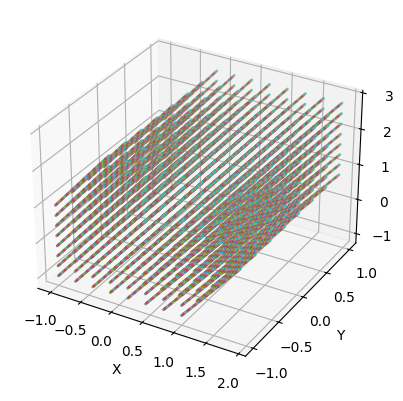

In [32]:
_ = simulate_vector_field_flow(initial_positions=cube_points,f1=poly1,f2=poly2,f3=poly3,dt=0.05,num_steps=100)

In [33]:
poly1_mod, poly2_mod, poly3_mod = add_local_attractor(m = np.array((0,0,0)),f1=poly1,f2=poly2,f3=poly3,k=5,sigma=0.9)

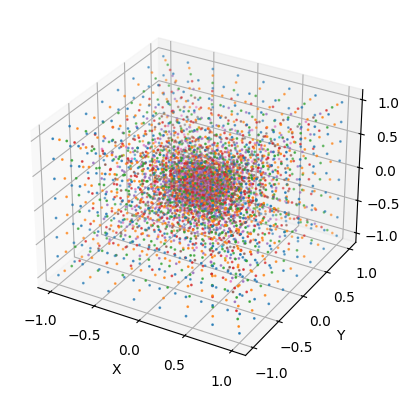

In [34]:
_ = simulate_vector_field_flow(initial_positions=cube_points,f1=poly1_mod,f2=poly2_mod,f3=poly3_mod,dt=0.05,num_steps=100)

In [35]:
def find_positions_by_type(
    volume,
    types
):
    """
    For a 3D integer array, find the coordinates of all voxels matching each of the given types.

    Args:
        volume (np.ndarray):
            A 3D NumPy array of dtype int (shape (n, m, o)).
        types (List[int]):
            A list of integer “types” to search for in `volume`.

    Returns:
        Dict[int, np.ndarray]:
            A dict mapping each type → an array of shape (K, 3), where K is the number
            of occurrences of that type, and each row is the (i, j, k) index in `volume`.
    """
    if volume.ndim != 3:
        raise ValueError(f"Expected a 3D array, got ndim={volume.ndim}")

    positions_by_type: Dict[int, np.ndarray] = {}
    for t in types:
        # np.argwhere returns an (K,3) array of coordinates where volume == t
        coords = np.argwhere(volume == t)
        positions_by_type[t] = coords

    return positions_by_type
def anisotropic_wave_collapse(
    dims,
    type_array,
    probability_vector,
    sparsity_factor=0.7,
    seed=0,
    sparse_holes=0,
    # NEU: Anisotrope Parameter
    vertical_bias=0.9,      # Wie stark vertikale Nachbarn bevorzugt werden (0-1)
    layer_boundaries=None,  # Optional: Liste von z-Indizes für Layer-Grenzen
    layer_type_modifiers=None  # Optional: Dict {layer_idx: prob_vector_modifier}
):
    """
    Anisotropic Wave Function Collapse für kortikale Strukturen.
    
    Vertikal (z-Achse): Starke Klusterbildung → Minicolumns
    Horizontal (xy): Normale Klusterbildung → Domänen
    
    Args:
        dims: (nx, ny, nz) - Grid-Dimensionen
        type_array: Liste der möglichen Zelltypen [0,1,2,...]
        probability_vector: Basis-Wahrscheinlichkeiten für jeden Typ
        sparsity_factor: 0-1, höher = mehr Klumpen (horizontal)
        seed: Random seed
        sparse_holes: Anzahl blockierter Zellen
        vertical_bias: 0-1, Zusätzlicher Boost für vertikale Nachbarn
        layer_boundaries: [z1, z2, ...] Optional Layer-Grenzen
        layer_type_modifiers: {layer_idx: [p0, p1, ...]} Überschreibt probs pro Layer
    
    Returns:
        np.ndarray: 3D-Array mit Zelltyp-Labels (dtype=int16)
    """
    
    # Neighbor offsets mit Gewichtungen
    NEIGHBOR_OFFSETS = []
    NEIGHBOR_WEIGHTS = []
    
    # Horizontale Nachbarn (xy-Ebene): basis sparsity
    for dx in (-1, 0, 1):
        for dy in (-1, 0, 1):
            if dx == 0 and dy == 0:
                continue
            NEIGHBOR_OFFSETS.append((dx, dy, 0))
            # Diagonale schwächer als direkte Nachbarn
            weight = sparsity_factor if (dx == 0 or dy == 0) else sparsity_factor * 0.7
            NEIGHBOR_WEIGHTS.append(weight)
    
    # Vertikale Nachbarn (z-Achse): viel stärker!
    vertical_sparsity = min(1.0, sparsity_factor + vertical_bias)
    NEIGHBOR_OFFSETS.append((0, 0, 1))   # oben
    NEIGHBOR_WEIGHTS.append(vertical_sparsity)
    NEIGHBOR_OFFSETS.append((0, 0, -1))  # unten
    NEIGHBOR_WEIGHTS.append(vertical_sparsity)
    
    NEIGHBOR_OFFSETS = np.array(NEIGHBOR_OFFSETS, dtype=np.int8)
    NEIGHBOR_WEIGHTS = np.array(NEIGHBOR_WEIGHTS, dtype=np.float32)
    
    # Init
    random.seed(seed + 3)
    np.random.seed(seed + 7)
    probability_vector = np.asarray(probability_vector, float)
    probability_vector /= probability_vector.sum()
    
    mask = np.zeros(dims, np.int8)
    if sparse_holes:
        idx = np.random.choice(mask.size, sparse_holes, replace=False)
        mask.ravel()[idx] = -1
    
    collapsed = -np.ones(dims, np.int16)
    H = np.full(dims, 999., np.float32)
    
    # Heap init
    heap = [(H[i,j,k], i, j, k) for i in range(dims[0])
                                  for j in range(dims[1])
                                  for k in range(dims[2]) if mask[i,j,k] == 0]
    heapq.heapify(heap)
    
    # Helper: Bestimme Layer für eine z-Koordinate
    def get_layer_idx(z):
        if layer_boundaries is None:
            return None
        for idx, boundary in enumerate(layer_boundaries):
            if z < boundary:
                return idx
        return len(layer_boundaries)
    
    # Helper: Hole Probs für aktuellen Layer
    def get_probs_for_layer(z):
        layer_idx = get_layer_idx(z)
        if layer_idx is not None and layer_type_modifiers and layer_idx in layer_type_modifiers:
            p = np.array(layer_type_modifiers[layer_idx], dtype=float)
            p /= p.sum()
            return p
        return probability_vector.copy()
    
    # Main collapse loop
    while heap:
        h, i, j, k = heapq.heappop(heap)
        if mask[i, j, k]:
            continue
        
        # Sammle Nachbar-Labels mit Gewichtung
        neighbor_labels = []
        neighbor_weights_used = []
        
        for offset, weight in zip(NEIGHBOR_OFFSETS, NEIGHBOR_WEIGHTS):
            ni, nj, nk = i + offset[0], j + offset[1], k + offset[2]
            
            # Bounds check
            if not (0 <= ni < dims[0] and 0 <= nj < dims[1] and 0 <= nk < dims[2]):
                continue
            
            if mask[ni, nj, nk] == 1:  # collapsed
                label = collapsed[ni, nj, nk]
                neighbor_labels.append(label)
                neighbor_weights_used.append(weight)
        
        # Berechne Probs basierend auf Nachbarn
        p = get_probs_for_layer(k)
        
        if neighbor_labels:
            # Gewichtetes Boosting
            counts = np.zeros(len(type_array), dtype=float)
            for label, weight in zip(neighbor_labels, neighbor_weights_used):
                if label in type_array:
                    idx = type_array.index(label)
                    counts[idx] += weight
            
            # Normalisiere counts
            if counts.sum() > 0:
                counts /= counts.sum()
            
            # Mische mit Base-Probs
            l = len(type_array)
            l1 = int((1 - sparsity_factor) * l)
            
            boost = counts * (1 - sparsity_factor) / (l + l1)
            boost_self = boost * l1
            boost_rest = boost
            
            redistribution = np.full(l, boost_rest.mean())
            for idx in range(l):
                redistribution[idx] += boost_self[idx]
            
            p = p + redistribution
            p = np.maximum(p, 0)  # keine negativen Probs
            if p.sum() > 0:
                p /= p.sum()
            else:
                p = get_probs_for_layer(k)  # fallback
        
        # Collapse
        choice = np.random.choice(type_array, p=p)
        collapsed[i, j, k] = choice
        mask[i, j, k] = 1
        H[i, j, k] = 0.0
        
        # Update uncollapsed neighbors
        for offset in NEIGHBOR_OFFSETS:
            ni, nj, nk = i + offset[0], j + offset[1], k + offset[2]
            if (0 <= ni < dims[0] and 0 <= nj < dims[1] and 0 <= nk < dims[2] 
                and mask[ni, nj, nk] == 0):
                H[ni, nj, nk] = 1.0
                heapq.heappush(heap, (H[ni, nj, nk], ni, nj, nk))
    
    return collapsed

# Wrapper für Backwards-Kompatibilität
def wave_collapse_bio(
    dims,
    type_array,
    probability_vector,
    sparsity_factor=0.7,
    seed=0,
    sparse_holes=0
):
    """
    Drop-in Replacement für alten wave_collapse mit biologischen Defaults
    """
    return anisotropic_wave_collapse(
        dims=dims,
        type_array=type_array,
        probability_vector=probability_vector,
        sparsity_factor=sparsity_factor,
        seed=seed,
        sparse_holes=sparse_holes,
        vertical_bias=0.25,  # 95% statt 70% für vertikale Nachbarn
        layer_boundaries=None,
        layer_type_modifiers=None
    )


In [36]:
def cluster_and_flow(
    grid_size,
    m,
    rot_theta,
    rot_phi,
    transform_matrix,
    wave_params,
    types,
    flow_functions,
    dt,
    num_steps,
    old=True,
    biological=False,
    plot_clusters=False,
    title="Cluster-Flows",
    vertical_bias=0.25,  # Nur relevant wenn biological=True
    layer_boundaries=None,  # z.B. [2, 5, 8] für Layer-Grenzen
    layer_type_modifiers=None  # z.B. {0: [0.8, 0.1, 0.1], 1: [0.3, 0.6, 0.1]}
):
    """
    1) Create a cubic grid
    2) Apply a one‐time transformation (rotate/translate/scale)
    3) Generate the `neuron_type_array` via wave_collapse variant
    4) Split the grid into sub‐arrays by type
    5) Simulate each sub‐array under its own flow field
    6) Plot all resulting clusters (optional)
    7) Return the list of final position arrays
    
    Args:
        biological (bool): If True, uses anisotropic_wave_collapse with 
                          vertical minicolumn bias. If False, uses standard WFC.
        vertical_bias (float): 0-1, additional weight for vertical neighbors
                              (creates stronger minicolumns). Only used if biological=True.
        layer_boundaries (list): Optional z-indices marking layer transitions.
                                Only used if biological=True.
        layer_type_modifiers (dict): Override probability_vector per layer.
                                    Format: {layer_idx: [p0, p1, ...]}
                                    Only used if biological=True.
    """
    # 1-2: Generate and transform grid
    grid = generate_cube(grid_size)
    #### DIESER SHIT HIER pts sollte mein eigenes kluster  sein, von beliebiger form
    pts = transform_points(
        grid, m=m, rot_theta=rot_theta,
        rot_phi=rot_phi, transform_matrix=transform_matrix,
        plot=False
    )
    
    # 3: Generate neuron_type_array with appropriate WFC variant
    if biological:
        neuron_type_array = anisotropic_wave_collapse(
            dims=grid_size,
            type_array=types,
            probability_vector=wave_params['probability_vector'],
            sparsity_factor=wave_params['sparsity_factor'],
            seed=wave_params.get('seed', 0),
            sparse_holes=wave_params['sparse_holes'],
            vertical_bias=vertical_bias,
            layer_boundaries=layer_boundaries,
            layer_type_modifiers=layer_type_modifiers
        )
    elif old:
        # Alter entropy-basierter WFC (langsam aber genau)
        neuron_type_array = wave_collapse_old(
            dims=grid_size,
            sparse_holes=wave_params['sparse_holes'],
            sparsity_factor=wave_params['sparsity_factor'],
            probability_vector=wave_params['probability_vector'],
            type_array=types
        )
    else:
        # Schneller heap-basierter WFC (Standard)
        neuron_type_array = wave_collapse(
            dims=grid_size,
            sparse_holes=wave_params['sparse_holes'],
            sparsity_factor=wave_params['sparsity_factor'],
            probability_vector=wave_params['probability_vector'],
            type_array=types
        )
    
    # 4: Find positions by type and map to transformed coordinates
    idx = find_positions_by_type(neuron_type_array, types)
    
    nx, ny, nz = grid_size
    slice_size = ny * nz
    row_size = nz
    arrays = []
    
    for t in types:
        tripels = idx[t]
        flat_idx = tripels[:, 0] * slice_size + tripels[:, 1] * row_size + tripels[:, 2]
        arrays.append(pts[flat_idx])
    
    # 5: Apply flow fields to each cluster
    clusters = []
    for (f1, f2, f3), cluster_pts in zip(flow_functions, arrays):
        final_positions = simulate_vector_field_flow(
            initial_positions=cluster_pts,
            dt=dt, f1=f1, f2=f2, f3=f3,
            num_steps=num_steps,
            plot=False, scatter_size=1.0,
            create_object=False
        )
        clusters.append(final_positions)
    
    # 6: Optional visualization
    if plot_clusters:
        plot_point_clusters(clusters, title=title)
    
    # 7: Return final positions
    return clusters



In [37]:
def cluster_and_flow_flexible(
    points,  # Beliebige Punktwolke
    grid_size,  # Grid für WFC
    wave_params,
    types,
    flow_functions,
    dt,
    num_steps,
    old=True,
    biological=False,
    plot_clusters=False,
    title="Cluster-Flows",
    vertical_bias=0.25,
    layer_boundaries=None,
    layer_type_modifiers=None
):
    """Flexible Version - mappt beliebige Punkte auf WFC-Grid"""
    
    # 1. WFC auf abstraktem Grid
    if biological:
        neuron_type_array = anisotropic_wave_collapse(
            dims=grid_size,
            type_array=types,
            probability_vector=wave_params['probability_vector'],
            sparsity_factor=wave_params['sparsity_factor'],
            seed=wave_params.get('seed', 0),
            sparse_holes=wave_params['sparse_holes'],
            vertical_bias=vertical_bias,
            layer_boundaries=layer_boundaries,
            layer_type_modifiers=layer_type_modifiers
        )
    else:
        neuron_type_array = wave_collapse(
            dims=grid_size,
            type_array=types,
            probability_vector=wave_params['probability_vector'],
            sparsity_factor=wave_params['sparsity_factor'],
            seed=wave_params.get('seed', 0),
            sparse_holes=wave_params['sparse_holes']
        )
    
    # 2. Mapping der Punkte
    points = np.asarray(points)
    n_points = len(points)
    
    # Bounding Box
    mins = points.min(axis=0)
    maxs = points.max(axis=0)
    ranges = maxs - mins + 1e-10
    
    # Normalisiere auf [0,1]
    normalized = (points - mins) / ranges
    
    # Map auf Grid
    nx, ny, nz = grid_size
    grid_indices = np.floor(normalized * [nx-1, ny-1, nz-1]).astype(int)
    grid_indices = np.clip(grid_indices, [0,0,0], [nx-1, ny-1, nz-1])
    
    # 3. Typ-Zuweisung
    point_types = neuron_type_array[grid_indices[:, 0], 
                                    grid_indices[:, 1], 
                                    grid_indices[:, 2]]
    
    # 4. Nach Typ gruppieren
    clusters = []
    for t in types:
        mask = (point_types == t)
        cluster_pts = points[mask]
        clusters.append(cluster_pts)
    
    # 5. Flow anwenden
    final_clusters = []
    for (f1, f2, f3), cluster_pts in zip(flow_functions, clusters):
        if len(cluster_pts) == 0:
            final_clusters.append(cluster_pts)
            continue
            
        final_positions = simulate_vector_field_flow(
            initial_positions=cluster_pts,
            dt=dt, f1=f1, f2=f2, f3=f3,
            num_steps=num_steps,
            plot=False
        )
        final_clusters.append(final_positions)
    
    if plot_clusters:
        plot_point_clusters(final_clusters, title=title)
    
    return final_clusters


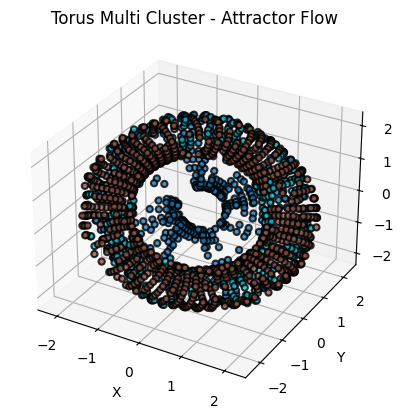

Cluster 0 (Typ 0): 561 Points
Cluster 1 (Typ 1): 876 Points
Cluster 2 (Typ 2): 353 Points


In [38]:
# ============= KORRIGIERTES BEISPIEL =============

# 1. Erstelle eine Punktwolke (z.B. Torus)
input_points = generate_torus(
    R=2.0, 
    r=0.5, 
    grid_size_list=(60, 30),
    rot_theta=30,
    rot_phi=45
)

# 2. Definiere Polynome für Flow-Fields
poly_gen = PolynomGenerator(n=2, decay=0.5)
poly1, _, _ = poly_gen.generate(num_terms=3, safe_mode=True, max_power=2, max_coeff=0.3)
poly2, _, _ = poly_gen.generate(num_terms=2, safe_mode=True, max_power=1, max_coeff=0.2)
poly3, _, _ = poly_gen.generate(num_terms=4, safe_mode=True, max_power=2, max_coeff=0.4)

# 3. Setup für 3 Neuron-Typen - KORRIGIERT!
types = [0, 1, 2]


# Oder noch besser mit np.zeros_like für Klarheit:
flow_functions = [
    (poly1_mod, poly2_mod, poly3_mod),  # Typ 0: komplexeres Flow
    (lambda x,y,z: 0.1*x, lambda x,y,z: 0.1*y, lambda x,y,z: -0.2*z),  # Typ 1: einfacher
    (lambda x,y,z: -0.05*y, lambda x,y,z: 0.05*x, lambda x,y,z: np.zeros_like(x))   # Typ 2: Rotation in xy-Ebene
]

wave_params = {
    'probability_vector': np.array([0.3, 0.5, 0.2]),  # 30% Typ0, 50% Typ1, 20% Typ2
    'sparsity_factor': 0.85,  # Starke Klusterbildung
    'sparse_holes': 50,  # Ein paar Löcher
    'seed': 42
}

# 4. Ausführen
result_clusters = cluster_and_flow_flexible(
    points=input_points,
    grid_size=(15, 15, 15),  # WFC-Grid
    wave_params=wave_params,
    types=types,
    flow_functions=flow_functions,
    dt=0.02,
    num_steps=20,
    old=True,
    biological=False,  
    vertical_bias=0.3,  # Minicolumn-Effekt
    plot_clusters=True,
    title="Torus Multi Cluster - Attractor Flow"
)

# 5. Einzelne Cluster visualisieren
print(f"Cluster 0 (Typ 0): {len(result_clusters[0])} Points")
print(f"Cluster 1 (Typ 1): {len(result_clusters[1])} Points")
print(f"Cluster 2 (Typ 2): {len(result_clusters[2])} Points")

# NEST

In [39]:
def create_CCW(
    positions,
    model='iaf_psc_alpha',
    plot=False,
    k=10.0,
    bidirectional = False,
    conn_dict_ex = {
        'rule': 'one_to_one'
    },
    syn_spec_ex = {
        'synapse_model': 'static_synapse',
        'weight': 30.0,
        'delay': 1.0
    },
    conn_dict_inh = {
        'rule': 'pairwise_bernoulli',
        'p': 1.0,
        'allow_autapses': False
    },
    syn_spec_inh = {
        'synapse_model': 'static_synapse',
        'weight': -k * nest.spatial.distance,
        'delay': 1.0
    },
    ):
    #~*~*~*~* START  *~*~*~*~#
    """
    Create a NEST neuron population at specified 3D positions.

    Args:
        conn_dict_ex, syn_spec_ex, conn_dict_inh, syn_spec_inh: dicts for the exh/inh synapses
        k(float): pA/mm
        plot(bool): the usual
        bidirectional(bool): creates exhib. Connections clockwise AND counterclockwise
        positions (np.ndarray): Array of shape (N,3) with (x,y,z) coordinates.
        model (str):           Name of the NEST neuron model to instantiate.

    Returns:
        list: List of NEST node IDs corresponding to the created neurons.
    """    
    #~*~*~*~* END  *~*~*~*~#
    
    
    positions=positions.tolist()
    nodes = nest.Create(model=model,positions=nest.spatial.free(pos=positions))
    
    if(plot):
        nest.PlotLayer(nodes)

    
    # connect the ring
    count=0

    for i in nodes:
        nest.Connect(i,nodes[(count+1)%len(nodes)],conn_dict_ex,syn_spec_ex)
        if(bidirectional):
            nest.Connect(nodes[(count+1)%len(nodes)],i,conn_dict_ex,syn_spec_ex)
            # for the case you don't want a signalgenerator but rather only one active area which can freely
            # slide in every direction on the circle 
        count+=1

    nest.Connect(nodes, nodes, conn_dict_inh, syn_spec_inh)

    # klappt.
    return nodes

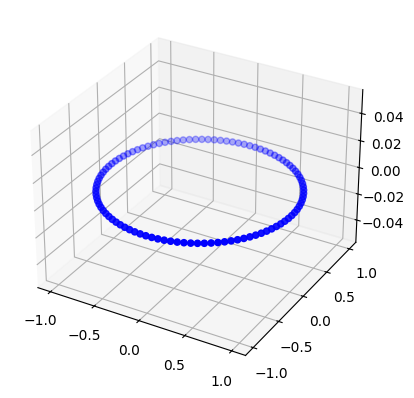

In [40]:
ccw = create_CCW(circle_points,plot=True)

In [41]:
def CCW_spike_recorder(ccw):
        
    #~*~*~*~* START  *~*~*~*~#
    """
    simply attaches spike recorder to every neuron in the CCW
    returns a list of tuples countaining theta->[n][0] (the angle relative to (1,0))
    in radians and the corresponding recorder->[n][1]
    """
    #~*~*~*~* END  *~*~*~*~#

    length = len(ccw)
    recorder_list = []
    for i, neuron in enumerate(ccw):
        theta = (i/length) * 2*np.pi
        spikerecorder = nest.Create("spike_recorder")
        nest.Connect(neuron, spikerecorder)
        recorder_list.append((theta,spikerecorder))#damit klar ist, in welche Richtung der Agent läuft
    return recorder_list

In [42]:
recorder_list = CCW_spike_recorder(ccw)
recorder_list[:5]

[(0.0, NodeCollection(metadata=None, model=spike_recorder, size=1, first=101)),
 (0.06283185307179587,
  NodeCollection(metadata=None, model=spike_recorder, size=1, first=102)),
 (0.12566370614359174,
  NodeCollection(metadata=None, model=spike_recorder, size=1, first=103)),
 (0.18849555921538758,
  NodeCollection(metadata=None, model=spike_recorder, size=1, first=104)),
 (0.25132741228718347,
  NodeCollection(metadata=None, model=spike_recorder, size=1, first=105))]

In [43]:
def connect_cone(
    cone_points,
    k=10.0,
    model='iaf_psc_alpha',
    # 80 % exhib
    conn_dict_ex = {
        'rule': 'pairwise_bernoulli',
        'p': 0.8,
        'allow_autapses': False
    },
    syn_spec_ex = {
        'synapse_model': 'static_synapse',
        'weight': (((nest.spatial.target_pos.z - nest.spatial.source_pos.z)**2)**0.5),
        'delay': 1.0
    },
    # 20 % inhib
    conn_dict_inh = {
        'rule': 'pairwise_bernoulli',
        'p': 0.2,
        'allow_autapses': False
    },
    syn_spec_inh = {
        'synapse_model': 'static_synapse',
        'weight': -k * (
            ((nest.spatial.target_pos.x - nest.spatial.source_pos.x)**2
           + (nest.spatial.target_pos.y - nest.spatial.source_pos.y)**2)
           ** 0.5# dependency on x-y euclidean distance
        ),
        'delay': 1.0
    }
    ):
     #~*~*~*~* START *~*~*~*~#

    """
    Create a recurrent network on cone-shaped positions with both excitatory and inhibitory connections.

    Args:
        cone_points (np.ndarray): Array of shape (N,3) with (x,y,z) coordinates of cone.
        k (float):              Scaling factor for inhibitory synaptic weights.
        conn_dict_ex (dict):    Excitatory connection rule for nest.Connect.
        syn_spec_ex (dict):     Excitatory synapse specifications; weight func of z-distance.
        conn_dict_inh (dict):   Inhibitory connection rule for nest.Connect.
        syn_spec_inh (dict):    Inhibitory synapse specifications; weight func of xy-distance.

    Returns:
        list: NEST node IDs of the created cone network.
    """
    #~*~*~*~* END *~*~*~*~#
    
    nodes = nest.Create(model=model, positions=nest.spatial.free(pos=cone_points.tolist()))
    nest.Connect(nodes, nodes, conn_dict_ex, syn_spec_ex)
    nest.Connect(nodes, nodes, conn_dict_inh, syn_spec_inh)
    return nodes

In [44]:
nest_cone = connect_cone(cone_points)
nest_cone[:2],nest_cone

(NodeCollection(metadata=spatial,
                model=iaf_psc_alpha, size=2, first=201, last=202),
 NodeCollection(metadata=spatial, model=iaf_psc_alpha, size=600, first=201, last=800))

In [45]:
def connect_cone_ccw(
        cone, 
        ccw,              
        syn_spec_strong={'synapse_model':'static_synapse', 'weight':10.0, 'delay':1.0}, 
        syn_spec_weak  ={'synapse_model':'static_synapse', 'weight': 2.0, 'delay':1.0}, 
        angle_width_deg=15.0
    ):
        #~*~*~*~* START  *~*~*~*~#

    """
    Connects two NEST populations based on their azimuthal (XY-plane) angular proximity.

    Each neuron in `cone_nodes` is connected to each neuron in `ccw_nodes`.
    If the angular difference between their positions (in the XY-plane) is within
    `angle_width_deg`, the connection uses `syn_spec_strong`, otherwise `syn_spec_weak`.

    Args:
        cone_nodes (List[int]): List of NEST node IDs for the "cone" population.
        ccw_nodes  (List[int]): List of NEST node IDs for the "ccw" population.
        angle_width_deg (float): Angular window (in degrees) for strong connections.
        syn_spec_strong (dict): Synapse specification for connections within the angular window.
        syn_spec_weak   (dict): Synapse specification for connections outside the window.
        conn_spec       (dict): Connection rule dictionary for nest.Connect.

    Returns:
        None: Connections are created in the NEST kernel; nothing is returned.
    """
        #~*~*~*~* END  *~*~*~*~#

    
    # costly preprocessing
    conn_spec   = {'rule': 'one_to_one'}
    angle_width = np.deg2rad(angle_width_deg)


    pos_ccw  = nest.GetPosition(ccw)
    pos_cone = nest.GetPosition(cone)

    theta_ccw  = [ (np.arctan2(y, x) + 2*np.pi) % (2*np.pi) for x, y, _ in pos_ccw ]
    theta_cone = [ (np.arctan2(y, x) + 2*np.pi) % (2*np.pi) for x, y, _ in pos_cone ]

    for idx_i, i in enumerate(ccw):
        ti = theta_ccw[idx_i]
        for idx_j, j in enumerate(cone):
            tj = theta_cone[idx_j]
            delta = abs(tj - ti)
            delta = min(delta, 2*np.pi - delta)
            if delta < angle_width:
                nest.Connect(j, i, conn_spec, syn_spec_strong)
            else:
                nest.Connect(j, i, conn_spec, syn_spec_weak)

In [46]:
connect_cone_ccw(nest_cone,ccw)

In [47]:
def create_blob_population(
    positions,
    conn_ex = {'rule': 'pairwise_bernoulli', 'p': 0.8, 'allow_autapses': False},
    syn_ex  = {'synapse_model': 'static_synapse', 'weight': 2.0, 'delay': 1.0},
    conn_in = {'rule': 'pairwise_bernoulli', 'p': 0.2, 'allow_autapses': False},
    syn_in  = {'synapse_model': 'static_synapse','weight': -10.0,'delay': 1.0},
    plot= False,
    neuron_type = "iaf_psc_alpha"
    ):
        #~*~*~*~* START  *~*~*~*~#

    """
    Create and connect a NEST population (“blob”) at specified 3D positions.

    Args:
        positions (np.ndarray): Array of shape (N,3) with neuron coordinates.
        conn_ex (dict):       Excitatory connection rule for nest.Connect.
        syn_ex (dict):        Excitatory synapse parameters.
        conn_in (dict):       Inhibitory connection rule for nest.Connect.
        syn_in (dict):        Inhibitory synapse parameters.
        neuron_type (str):    Name of the NEST neuron model to instantiate.
        plot (bool):          If True, show a 3D scatter of positions and PlotLayer.

    Returns:
        list: The list of NEST node IDs created.
    """
        #~*~*~*~* END  *~*~*~*~#

    blob_pop = nest.Create(
        neuron_type,
        positions.shape[0],
        positions=nest.spatial.free(positions.tolist())
    )

    nest.Connect(blob_pop, blob_pop, conn_ex, syn_ex)
    nest.Connect(blob_pop, blob_pop, conn_in, syn_in)

    if plot:
        from mpl_toolkits.mplot3d import Axes3D
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(positions[:,0], positions[:,1], positions[:,2], s=2)
        ax.set_xlabel('X [mm]')
        ax.set_ylabel('Y [mm]')
        ax.set_zlabel('Z [mm]')
        plt.show()
        nest.PlotLayer(blob_pop)
    return blob_pop

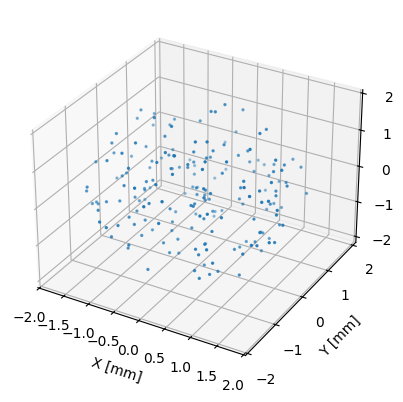

NodeCollection(metadata=spatial, model=iaf_psc_alpha, size=200, first=801, last=1000)

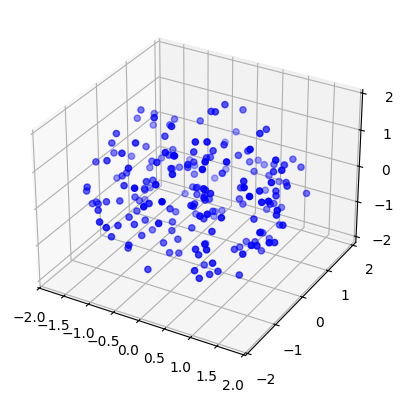

In [48]:
create_blob_population(blob_points,plot=True)

In [49]:
def blob(n = 100,
    m = np.zeros(3),
    r = 1.0,
    scaling_factor = 1.0,
    conn_ex = {'rule': 'pairwise_bernoulli', 'p': 0.8, 'allow_autapses': False},
    syn_ex  = {'synapse_model': 'static_synapse', 'weight': 2.0, 'delay': 1.0},
    conn_in = {'rule': 'pairwise_bernoulli', 'p': 0.2, 'allow_autapses': False},
    syn_in  = {'synapse_model': 'static_synapse','weight': -10.0,'delay': 1.0},
    plot= False,
    neuron_type = "iaf_psc_alpha"    
        ):
            #~*~*~*~* START  *~*~*~*~#
    """
    Create a spatially distributed “blob” of NEST neurons and interconnect them
    with specified excitatory and inhibitory rules.

    This function first generates `n` random 3D points within a sphere of radius `r`
    centered at `m`, scaled by `scaling_factor`. It then instantiates a NEST population
    of size `n` at these coordinates and connects the neurons pairwise according to
    the provided excitatory and inhibitory connection parameters.

    Args:
        n (int): Number of neurons to generate in the blob.
        m (np.ndarray): 3-vector specifying the center of the sphere.
        r (float): Radius of the sphere used for point generation.
        scaling_factor (float): Uniform scaling factor applied to all coordinates.
        conn_ex (dict): NEST connection rule for excitatory synapses.
        syn_ex (dict): Parameters for excitatory synapses (model, weight, delay).
        conn_in (dict): NEST connection rule for inhibitory synapses.
        syn_in (dict): Parameters for inhibitory synapses (model, weight, delay).
        plot (bool): If True, display a 3D scatter of neuron positions and invoke
                     NEST’s PlotLayer.
        neuron_type (str): Name of the NEST neuron model to create (e.g., "iaf_psc_alpha").

    Returns:
        list: List of NEST node IDs corresponding to the created neurons.
    """
    
            #~*~*~*~* END  *~*~*~*~#

    
    
    # Creates Blob.
    pos = blob_positions(
        n=n,
        m=m,
        r=1.0,
        scaling_factor=SCALING_FACTOR
    )
    blob_pop = create_blob_population(
        positions=pos,
        conn_ex=conn_ex,
        syn_ex=syn_ex,
        conn_in=conn_in,
        syn_in=syn_in,
        plot=plot,
        neuron_type = neuron_type
    )
    
    
    return blob_pop

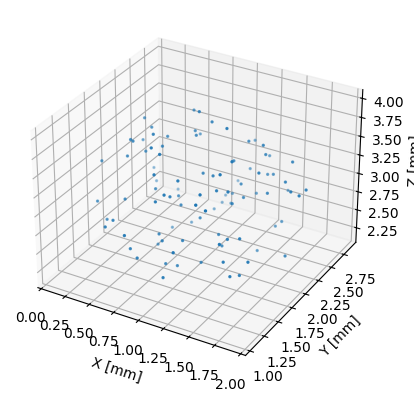

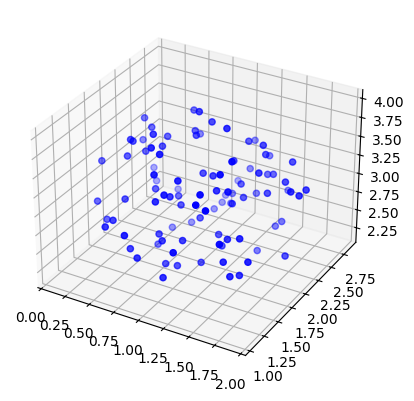

In [50]:
blob_pop = blob(n=100,m=np.array([1,2,3]),plot=True)

In [51]:
def connect_blob_cone(
    blob,
    cone,
    m = np.zeros(3),
    angle_width_deg = 10.0,
    conn_ex_c = {'rule': 'pairwise_bernoulli', 'p': 0.6, 'allow_autapses': False},
    conn_in_c  = {'rule': 'pairwise_bernoulli', 'p': 0.4, 'allow_autapses': False},
    generic_conn = {'rule': 'pairwise_bernoulli', 'p': 0.01, 'allow_autapses': False},
    generic_syn = {'synapse_model': 'static_synapse', 'weight': 1.0, 'delay': 1.5}
):
        #~*~*~*~* START  *~*~*~*~#

    """
    Connects two NEST populations ("blob" → "cone" and back) using:
      1. generic blob→cone connections (generic_conn, generic_syn)
      2. angle‐dependent cone→blob connections:
         - if Δθ ≤ angle_width_deg: excitatory (conn_ex_c, syn_ex_c)
         - else: inhibitory (conn_in_c, syn_in_c), with delay clipped to ≥1 ms

    """
        #~*~*~*~* END  *~*~*~*~#

    nest.Connect(blob, cone, generic_conn, generic_syn)


    half = np.deg2rad(angle_width_deg)
    pos_blob = np.array(nest.GetPosition(blob))
    pos_cone = np.array(nest.GetPosition(cone))
    th_blob  = (np.arctan2(pos_blob[:,1],pos_blob[:,0]) + 2*np.pi)% (2*np.pi)
    th_cone  = (np.arctan2(pos_cone[:,1],pos_cone[:,0]) + 2*np.pi)% (2*np.pi)
    blob_ids = nest.GetStatus(blob, 'global_id')
    cone_ids = nest.GetStatus(cone, 'global_id')

    pre_exc, post_exc, w_exc, d_exc = [], [], [], []
    pre_inh, post_inh, w_inh, d_inh = [], [], [], []

    for bid, tb, pB in zip(blob_ids, th_blob, pos_blob):
        for cid, tc, pC in zip(cone_ids, th_cone, pos_cone):
            delta = abs(tc - tb)
            delta = min(delta, 2*np.pi - delta)
            if delta <= half:
                pre_exc.append(cid)
                post_exc.append(bid)

                dist = np.linalg.norm(pC - pB)
                w_exc.append(2.4 + 1.2 * dist)
                d_exc.append(1.0)
            else:
                pre_inh.append(cid)
                post_inh.append(bid)
                dx, dy = pC[0] - m[0], pC[1] - m[1]
                w_inh.append(1.0 + dx*dx + dy*dy)
                raw = np.random.exponential(scale=2.0) * np.linalg.norm(pC - pB)
                d_inh.append(max(raw, 1.0))

    if pre_exc:
        nest.Connect(
            pre_exc, post_exc,
            {'rule':'one_to_one'},
            {'synapse_model':'static_synapse',
             'weight': np.array(w_exc),
             'delay':  np.array(d_exc)}
        )
    if pre_inh:
        nest.Connect(
            pre_inh, post_inh,
            {'rule':'one_to_one'},
            {'synapse_model':'static_synapse',
             'weight': np.array(w_inh),
             'delay':  np.array(d_inh)}  # now >= 1
        )

In [52]:
connect_blob_cone(blob_pop,nest_cone)

In [53]:
def grid2visual(
                grid,
                K=10,
                m=np.array([0.0,0.0,0.0]),
                syn_dict_ex = {
                    "synapse_model": "static_synapse",
                    "weight": 50.0,    
                    "delay": 1.0       
                },
                syn_dict_in = {
                    "synapse_model": "static_synapse",
                    "weight": -40.0,   
                    "delay": 1.0       
                },
                conn_dict_ex = {
                    "rule": "pairwise_bernoulli",
                    "p": 0.7,                
                    "allow_autapses": False
                },
                syn_spec_ex = {
                    "synapse_model": "static_synapse",
                    "weight": 30.0,          
                    "delay": 1.5             
                },
                conn_dict_inh = {
                    "rule": "pairwise_bernoulli",
                    "p": 0.3,                
                    "allow_autapses": False
                },
                syn_spec_inh = {
                    "synapse_model": "static_synapse",
                    "weight": -60.0,         
                    "delay": 1.5             
                },
                conn_dict_layer = {
                    "rule": "all_to_all",    
                    "allow_autapses": False
                },
                syn_dict_layer = {
                    "synapse_model": "stdp_synapse",
                    "alpha": 1.0,            
                    "lambda": 0.01,          
                    "tau_plus": 20.0         
                }
    ):
        #~*~*~*~* START  *~*~*~*~#

    """
    Build a layered spiking neural network from a list of 3D grid layers,
    apply feed-forward Poisson input and noise to the first layer, connect
    successive layers with STDP synapses, and project the final layer into
    a visual blob population.

    Args:
        grid: A list of 3D coordinate arrays, one per layer (shape (Ni, 3)).
        K: Unused placeholder parameter for future extensions.
        syn_dict_ex: Excitatory synapse spec for Poisson input to the first layer.
        syn_dict_in: Inhibitory synapse spec for noise input to the first layer.
        conn_dict_ex: Connection rule for the final layer → blob excitatory mapping.
        syn_spec_ex: Synapse spec for the final layer → blob excitatory mapping.
        conn_dict_inh: Connection rule for the final layer → blob inhibitory mapping.
        syn_spec_inh: Synapse spec for the final layer → blob inhibitory mapping.
        conn_dict_layer: Connection rule for inter-layer connections.
        syn_dict_layer: Synapse spec (STDP) for inter-layer connections.


    Returns:
        poisson_generators: IDs of Poisson generators providing excitatory input.
        noise_generators: IDs of Poisson generators providing inhibitory noise.
        populations: List of neuron ID lists, one for each grid layer.
        blob_pop: Neuron ID list of the final visual blob population.
    """
        #~*~*~*~* END  *~*~*~*~#

    
    length = 0
    populations = []
    poisson_generators = []
    noise_generators = []
    
    for i,layer in enumerate(grid):
        length+=1
        pop = nest.Create("iaf_psc_alpha",len(layer.tolist()),positions=nest.spatial.free(layer.tolist()))
        if i==0:
            for neuron in pop:
                ex = nest.Create("poisson_generator")
                noise = nest.Create("poisson_generator")
                nest.Connect(ex, neuron, syn_spec=syn_dict_ex)
                nest.Connect(noise, neuron, syn_spec=syn_dict_in)
                poisson_generators.append(ex)
                noise_generators.append(noise)
                #simnulate the receptive field through poisson generators 
        populations.append(pop)
       
        
    
    blob_pop = blob(n=800,plot=False,m=m)
    
    
    for idx in range(len(populations)-1):# all except for the last layer
        nest.Connect(
            populations[idx],
            populations[idx+1],
            conn_spec=conn_dict_layer,
            syn_spec=syn_dict_layer
        )
    
    # Final layer -> visual blob: inhibitory mapping
    
    nest.Connect(populations[-1], blob_pop, conn_dict_ex, syn_spec_ex)
    nest.Connect(populations[-1], blob_pop, conn_dict_inh, syn_spec_inh)
    
    return poisson_generators, noise_generators, populations, blob_pop



In [54]:
old_dummy_vis = grid2visual(create_Grid(grid_size_list=[10,20]))

In [55]:
def input_to_receptive_field(image_array, poisson_generators, max_rate=200.0):
    """
    Map a grayscale image into Poisson input rates for a corresponding array of spike generators.

    Each pixel (0–255) is linearly scaled to a firing rate between 0 and `max_rate` Hz,
    then assigned to the matching Poisson generator.

    Args:
        image_array (np.ndarray):
            Input image of arbitrary shape, with values in [0, 255].
        poisson_generators (List[int]):
            List of NEST Poisson generator IDs; length must match image_array.size.
        max_rate (float):
            Maximum firing rate (Hz) corresponding to pixel value 255.

    Notes:
        - If `image_array.size` ≠ `len(poisson_generators)`, the mismatch is currently ignored.
          You may wish to add error handling for length mismatches.
    """
    if image_array.size != len(poisson_generators):
        print("POISSON_GENERATOR ANZAHL ENTSPRICHT NICHT DER GRÖßE DES IMAGE_ARRAYS!!!ELF\nTipp: Funktion input_to_receptive_field ist das Problem\n")
        pass # da es noch genug zu tun gibt, überspringe ich jetzt sowas. WITH GREAT POWER COMES GREAT RESPONSIBILITY


    flat_image = image_array.flatten()
    scaled_rates = (flat_image / 255.0) * max_rate

    for i, rate in enumerate(scaled_rates):#the timing scares me.
        nest.SetStatus([poisson_generators[i]], {'rate': float(rate)})


In [56]:
def clusters_to_neurons(
    clusters, 
    neuron_models
    ):
    """
    Create NEST neuron populations from clusters of 3D coordinates.

    Args:
        clusters (List[np.ndarray]):
            A list of NumPy arrays, each of shape (K_i, 3), representing the (x, y, z)
            positions of K_i neurons in cluster i.
        neuron_models (List[str]):
            A list of NEST neuron model names (e.g. "iaf_psc_alpha", "izhikevich",
            "hh_psc_alpha"), one for each cluster. Must have the same length as `clusters`.

    Returns:
        List[nest.NodeCollection]:
            A list of NodeCollections, one per cluster, containing the created neurons
            of the specified model placed at the given positions.
    """
    populations = []
    for idx, pts in enumerate(clusters):
        model = neuron_models[idx]

        n_cells = pts.shape[0]

        nodes = nest.Create(n=n_cells, model=model,positions=nest.spatial.free(pos=pts.tolist()))


        populations.append(nodes)
    return populations

In [57]:
neuron_models=["aeif_cond_alpha","iaf_psc_alpha","hh_psc_alpha"]

clusters_to_neurons(result_clusters,neuron_models)


[NodeCollection(metadata=spatial, model=aeif_cond_alpha, size=561, first=2601, last=3161),
 NodeCollection(metadata=spatial, model=iaf_psc_alpha, size=876, first=3162, last=4037),
 NodeCollection(metadata=spatial, model=hh_psc_alpha, size=353, first=4038, last=4390)]

# Some Test Functions

In [58]:

def xy_distance(a, b):
    # ignore z: lateral distance
    return np.linalg.norm(a[:2] - b[:2])

def eye_lgn_layer(gsl = 16,plot=False): # grid side length
    eye_layer_size = [gsl,gsl,gsl,gsl,gsl,gsl,gsl,gsl] #r,g,b,light,ganglia_r,ganglia_g, ganglia_b

    lgn_layer_size = [gsl,gsl,gsl,gsl,gsl] #not so sure anymore about 2x2 sight split. 
    # maybe just attach to different layers
    # r,g,b,light,merge_layer-> project
    # gsl grid side length


    eye_1 = create_Grid(m = np.array([1,gsl,10]),grid_size_list = eye_layer_size, plot = False, rot_phi = 0)
    eye_2 = create_Grid(m = np.array([1,-2*gsl,10]),grid_size_list = eye_layer_size, plot = False, rot_phi = 0)


    LGN_1 = create_Grid(m = np.array([20,gsl,15]),grid_size_list = lgn_layer_size, plot = False, rot_phi = 0)
    LGN_2 = create_Grid(m = np.array([20,-2*gsl,15]),grid_size_list = lgn_layer_size, plot = False, rot_phi = 0)



    V1_projection = create_Grid(m = np.array([10,0,0]),grid_size_list=[gsl],rot_theta=0.0,rot_phi=90)



    if plot:
        eyes = eye_1 + eye_2
        plot_point_clusters(eyes,marker_size = 10, alpha = 0.5,linewidths=0.1)
        plot_point_clusters_normalized(eyes,marker_size = 2, alpha = 0.5,linewidths=0.1)
        lgns = LGN_1 + LGN_2
        plot_point_clusters(lgns,marker_size = 10, alpha = 0.5,linewidths=0.1)
        plot_point_clusters_normalized(lgns,marker_size = 2, alpha = 0.5,linewidths=0.1)
    return [eye_1,eye_2,LGN_1,LGN_2,V1_projection]


def vis_cortex_pos(
    gsl          = 16,           # grid side length
    col_height   = 2.0,          
    cells_per_col= 140,          
    rot_xy       = (0.0, 90.0),        
    grid_size        = None,
    rot_theta        = 0,
    rot_phi          = 0,
    transform_matrix = np.diag([1,1,1]),
    dt               = 0.01,
    area_specs = None,
    flow_functions = None,
    experiments = None,
    plot=False):

    if grid_size is None:
        grid_size=np.array([gsl,gsl,gsl])
    if area_specs is None:
        area_specs = {
            "V1": dict(offset_x=10, inner=0.10, outer=0.15),
            "V2": dict(offset_x= 8, inner=0.15, outer=0.20),
            "V3": dict(offset_x= 6, inner=0.20, outer=0.30),
            "V4": dict(offset_x= 4, inner=0.30, outer=0.40),
            "V5": dict(offset_x= 2, inner=0.40, outer=0.45),
            "V6": dict(offset_x= 0, inner=0.45, outer=0.50),
        }
    if experiments is None:
        experiments = {
            "V1C": dict(
                m               = np.array([0,0,-9]),
                wave_params     = dict(sparse_holes=0,
                                       sparsity_factor=0.8,
                                       probability_vector=[0.35,0.25,0.10,0.05,0.20,0.05]),
                types           = [0,1,2,3,4,5],
                num_steps       = 10,
                title           = "V1 computational body"
            ),

            "V2C": dict(
                m               = np.array([0,0,-7]),
                wave_params     = dict(sparse_holes=0,
                                       sparsity_factor=0.8,
                                       probability_vector=[0.30,0.15,0.20,0.05,0.25]),
                types           = [0,1,2,3,4],
                num_steps       = 10,
                title           = "V2 computational body"
            ),
                "V3C": dict(
                m               = np.array([0,0,-5]),
                wave_params     = dict(sparse_holes=0,
                                       sparsity_factor=0.8,
                                       probability_vector=[0.3,0.15,0.15,0.05,0.2]),
                types           = [0,1,2,3,4],
                num_steps       = 10,
                title           = "V3 computational body"
            ),
                "V4C": dict(
                m               = np.array([0,0,-3]),
                wave_params     = dict(sparse_holes=0,
                                       sparsity_factor=0.8,
                                       probability_vector=[0.25,0.25,0.1,0.05,0.15,0.1]),
                types           = [0,1,2,3,4,5],
                num_steps       = 10,
                title           = "V4 computational body"
            ),
                "V5C": dict(
                m               = np.array([0,0,-1]),
                wave_params     = dict(sparse_holes=0,
                                       sparsity_factor=0.8,
                                       probability_vector=[0.45,0.25,0.1,0.1,0.1]),
                types           = [0,1,2,3,4],
                num_steps       = 10,
                title           = "V5 computational body"
            ),
                "V6C": dict(
                m               = np.array([0,0,1]),
                wave_params     = dict(sparse_holes=0,
                                       sparsity_factor=0.8,
                                       probability_vector=[0.35,0.25,0.1,0.05,0.2,0.05]),
                types           = [0,1,2,3,4,5],
                num_steps       = 10,
                title           = "V6 computational body"
            )
        }


    if flow_functions is None:
        f1 = lambda x,y,z : 1.0/(0.3*x**2 + 0.3*y**2 + 0.15)
        flow_functions = [(lambda x,y,z:x,
                           lambda x,y,z:y,
                           f1)] * 6  # same tripples, list operation



    results = {}
    all_columns  = {} 



    for name, spec in area_specs.items():

        grid_layers   = create_Grid(
            m           = np.array([spec["offset_x"], 0, 0]),
            grid_size_list=[gsl],
            rot_theta   = rot_xy[0],
            rot_phi     = rot_xy[1],
            plot        = False
        )
        projection_xy = grid_layers[0]

        columns = []
        for center in projection_xy:
            col_pts = create_cone(
                m             = center,
                n             = cells_per_col,
                inner_radius  = spec["inner"],
                outer_radius  = spec["outer"],
                height        = col_height,
                rot_theta     = 0.0,
                rot_phi       = 0.0,
                plot          = False
            )
            columns.append(col_pts)
        all_columns[name] = columns




    for name, cfg in experiments.items():
        res = cluster_and_flow(
            grid_size      = grid_size,
            m              = cfg["m"],
            rot_theta      = rot_theta,
            rot_phi        = rot_phi,
            transform_matrix = transform_matrix,
            wave_params    = cfg["wave_params"],
            types          = cfg["types"],
            flow_functions = flow_functions,
            dt             = dt,
            num_steps      = cfg["num_steps"],
            plot_clusters  = plot,
            title          = cfg["title"]
        )
        results[name]=res


    if plot:
        for name, cols in all_columns.items():
            plot_point_clusters(cols,
                                marker_size = 2,
                                alpha       = 0.6,
                                linewidths  = 0.1,
                                title       = f"{name}-Säulen ({len(cols)} Stück)")
    return results, all_columns


In [59]:
def vis2neurons(
    Vn_pop,
    area2models=None,
    plot=False
    ):
    
    model_alias = {"iaf_cond_beta_gap": "iaf_cond_alpha"}
    if(area2models is None):
        area2models = {
            "V1": ["iaf_cond_alpha","aeif_cond_alpha","iaf_cond_exp",
                   "hh_psc_alpha","iaf_cond_alpha","iaf_cond_beta_gap"],
            "V2": ["aeif_cond_alpha","iaf_cond_exp","aeif_cond_alpha",
                   "hh_psc_alpha","iaf_cond_alpha"],
            "V3": ["aeif_cond_alpha","iaf_cond_exp","aeif_cond_alpha",
                   "hh_psc_alpha","iaf_cond_alpha"],               
            "V4": ["aeif_cond_alpha","iaf_cond_exp","hh_psc_alpha",
                   "gif_cond_exp","iaf_cond_alpha","iaf_cond_beta_gap"],
            "V5": ["iaf_cond_alpha","aeif_cond_alpha","hh_psc_alpha",
                   "izhikevich","iaf_cond_beta_gap"],
            "V6": ["iaf_cond_alpha","aeif_cond_alpha","hh_psc_alpha",
                   "iaf_psc_delta","iaf_cond_alpha","iaf_cond_beta_gap"]
        }
    Vn_neurons = {}
    for exp_name, clusters in Vn_pop.items():
        models = [model_alias.get(m, m) for m in area2models[exp_name[:2]]]
        models = (models * ((len(clusters) + len(models) - 1) // len(models)))[:len(clusters)]
        Vn_neurons[exp_name] = clusters_to_neurons(clusters, models)
    if(plot):
        for exp_name, cluster_pops in Vn_neurons.items():    
            for pop in cluster_pops:                         
                nest.PlotLayer(pop)
    return Vn_neurons

Test 1: Mit expliziten Punktwolken
Matrix Shape: (200, 50)
Werte-Bereich: [-1.000, 1.000]
Durchschnitt: -0.002

Test 2: Mit Default-Parametern
Default Matrix Shape: (64, 64)
Default Werte-Bereich: [-0.316, 0.795]

Test 3: Version 2 mit custom Transforms
Matrix2 Shape: (125, 125)
Matrix2 Werte-Bereich: [-1.000, 1.000]


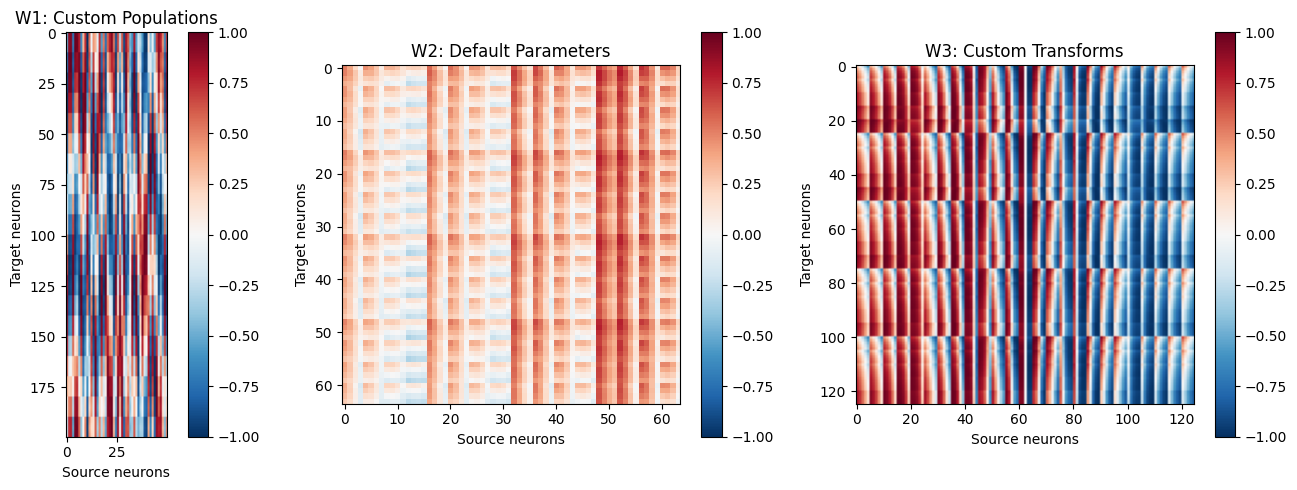

In [60]:
def test_direction_similarity_matrices():
    """Test beide Versionen der Direction Similarity Matrix Funktionen"""
    
    # 1. Test mit expliziten Punktwolken
    print("Test 1: Mit expliziten Punktwolken")
    
    # Erstelle zwei verschiedene Punktwolken
    pop1 = blob_positions(n=50, r=2.0, m=np.array([0, 0, 0]))
    pop2 = generate_torus(R=1.5, r=0.3, grid_size_list=(20, 10))
    
    # Definiere Vektorfelder (sicherstellen dass sie Arrays zurückgeben!)
    vecfield1 = (
        lambda x, y, z: 0.5 * x,
        lambda x, y, z: 0.5 * y, 
        lambda x, y, z: -0.2 * z
    )
    
    vecfield2 = (
        lambda x, y, z: -0.3 * y,
        lambda x, y, z: 0.3 * x,
        lambda x, y, z: 0.1 * np.ones_like(x)  # Sicherstellen dass Array zurückkommt
    )
    
    # Berechne Similarity Matrix
    W1 = generate_direction_similarity_matrix(
        pop1=pop1,
        pop2=pop2,
        vecfield1=vecfield1,
        vecfield2=vecfield2,
        plot=False  # Setze auf True für Visualisierung
    )
    
    print(f"Matrix Shape: {W1.shape}")
    print(f"Werte-Bereich: [{W1.min():.3f}, {W1.max():.3f}]")
    print(f"Durchschnitt: {W1.mean():.3f}")
    
    # 2. Test mit Default-Parametern
    print("\nTest 2: Mit Default-Parametern")
    
    W2 = generate_direction_similarity_matrix()
    print(f"Default Matrix Shape: {W2.shape}")
    print(f"Default Werte-Bereich: [{W2.min():.3f}, {W2.max():.3f}]")
    
    # 3. Test von generate_direction_similarity_matrix2
    print("\nTest 3: Version 2 mit custom Transforms")
    
    W3 = generate_direction_similarity_matrix2(
        grid_shape=(5, 5, 5),
        transform1={'m': [0, 0, 0], 'rot_theta': 45, 'rot_phi': 30},
        transform2={'m': [2, 2, 2], 'rot_theta': -45, 'rot_phi': 60},
        stretch1=(1.5, 1.0, 0.8),
        stretch2=(1.0, 1.2, 1.0),
        vecfield1=vecfield1,
        vecfield2=vecfield2,
        plot=False
    )
    
    print(f"Matrix2 Shape: {W3.shape}")
    print(f"Matrix2 Werte-Bereich: [{W3.min():.3f}, {W3.max():.3f}]")
    
    # 4. Visualisierung einer Matrix
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    im1 = axes[0].imshow(W1, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[0].set_title('W1: Custom Populations')
    axes[0].set_xlabel('Source neurons')
    axes[0].set_ylabel('Target neurons')
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(W2, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1].set_title('W2: Default Parameters')
    axes[1].set_xlabel('Source neurons')
    axes[1].set_ylabel('Target neurons')
    plt.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].imshow(W3, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[2].set_title('W3: Custom Transforms')
    axes[2].set_xlabel('Source neurons')
    axes[2].set_ylabel('Target neurons')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    return W1, W2, W3

# Führe Tests aus
W1, W2, W3 = test_direction_similarity_matrices()


#nest.Connect(pop1_nest, pop2_nest, syn_spec={'weight': W1.T.flatten()})  


# Building The Graph Structure

In [61]:
node_parameters = {
    "types": [0, 1, 2],
    "neuron_models": ["iaf_psc_alpha", "iaf_psc_exp", "iaf_psc_alpha"],
    "grid_size": [10, 10, 10],
    "m": [0.0, 0.0, 0.0],
    "rot_theta": 0.0,
    "rot_phi": 0.0,
    "transform_matrix": [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    "dt": 0.01,
    "old": True,
    "num_steps": 8,
    "plot_clusters": True, 
    "title": "3 populations",
    "sparse_holes": 0,
    "sparsity_factor": 0.9,
    "probability_vector": [0.3, 0.2, 0.4],
    "name": "TestNode",
    "id": 0,
    "distribution": [],
    "conn_prob": [],
    "polynom_max_power": 5,
    "coefficients": None,
    "center_of_mass": np.array((0.0, 0.0, 0.0)),
    "displacement": np.array((0.0, 0.0, 0.0)),
    "displacement_factor": 1.0,
    "field": None,
    
    "encoded_polynoms_per_type": [
        # Type 0 (x, y, z)
        [
            {'indices': [[0, 1], [0, 0]], 'coefficients': [1.5, 0.5], 'n': 5, 'decay': 0.5},
            {'indices': [[1, 1], [1, 0]], 'coefficients': [1.0, 0.3], 'n': 5, 'decay': 0.5},
            {'indices': [[2, 1], [2, 0]], 'coefficients': [0.8, 0.2], 'n': 5, 'decay': 0.5}
        ],
        # Type 1 (x, y, z)
        [
            {'indices': [[0, 1]], 'coefficients': [1.2], 'n': 5, 'decay': 0.5},
            {'indices': [[1, 1]], 'coefficients': [0.9], 'n': 5, 'decay': 0.5},
            {'indices': [[2, 1]], 'coefficients': [0.7], 'n': 5, 'decay': 0.5}
        ],
        # Type 2 (x, y, z)
        [
            {'indices': [[0, 1]], 'coefficients': [0.6], 'n': 5, 'decay': 0.5},
            {'indices': [[1, 1]], 'coefficients': [1.1], 'n': 5, 'decay': 0.5},
            {'indices': [[2, 1]], 'coefficients': [0.9], 'n': 5, 'decay': 0.5}
        ]
    ]
}


In [62]:
neuron_colors = {
    # AdEx Familie - Blautöne (adaptive exponential)
    "aeif_cond_alpha": "#1E88E5",
    "aeif_cond_alpha_multisynapse": "#1976D2",
    "aeif_cond_beta_multisynapse": "#1565C0",
    "aeif_cond_exp": "#0D47A1",
    "aeif_psc_alpha": "#42A5F5",
    "aeif_psc_delta": "#64B5F6",
    "aeif_psc_delta_clopath": "#90CAF9",
    "aeif_psc_exp": "#2196F3",
    
    # IAF Familie - Grüntöne (integrate-and-fire)
    "iaf_cond_alpha": "#43A047",
    "iaf_cond_beta": "#388E3C",
    "iaf_cond_exp": "#2E7D32",
    "iaf_cond_exp_sfa_rr": "#1B5E20",
    "iaf_cond_alpha_mc": "#66BB6A",
    "iaf_psc_alpha": "#4CAF50",
    "iaf_psc_alpha_multisynapse": "#81C784",
    "iaf_psc_delta": "#A5D6A7",
    "iaf_psc_exp": "#66BB6A",
    "iaf_psc_exp_multisynapse": "#8BC34A",
    "iaf_tum_2000": "#9CCC65",
    "iaf_chs_2007": "#AED581",
    "iaf_chxk_2008": "#C5E1A5",
    "iaf_psc_alpha_ps": "#558B2F",
    "iaf_psc_delta_ps": "#689F38",
    "iaf_psc_exp_htum": "#7CB342",
    "iaf_psc_exp_ps": "#8BC34A",
    "iaf_psc_exp_ps_lossless": "#9CCC65",
    
    # Hodgkin-Huxley Familie - Rottöne (biologisch realistisch)
    "hh_cond_exp_traub": "#D32F2F",
    "hh_cond_beta_gap_traub": "#C62828",
    "hh_psc_alpha": "#B71C1C",
    "hh_psc_alpha_clopath": "#E53935",
    "hh_psc_alpha_gap": "#F44336",
    
    # GIF Familie - Violett/Lila (stochastisch)
    "gif_cond_exp": "#7B1FA2",
    "gif_cond_exp_multisynapse": "#6A1B9A",
    "gif_psc_exp": "#4A148C",
    "gif_psc_exp_multisynapse": "#8E24AA",
    "gif_pop_psc_exp": "#9C27B0",
    
    # MAT Familie - Orangetöne (adaptive threshold)
    "mat2_psc_exp": "#F57C00",
    "amat2_psc_exp": "#EF6C00",
    
    # GLIF Familie - Cyan
    "glif_cond": "#00ACC1",
    "glif_psc": "#0097A7",
    
    # Spezielle Modelle - verschiedene Farben
    "izhikevich": "#FFB300",  # Amber
    "pp_psc_delta": "#5E35B1",  # Deep Purple
    "pp_cond_exp_mc_urbanczik": "#3949AB",  # Indigo
    "parrot_neuron": "#78909C",  # Blue Grey
    "parrot_neuron_ps": "#90A4AE",  # Blue Grey Light
    "mcculloch_pitts_neuron": "#455A64",  # Blue Grey Dark
    "siegert_neuron": "#00897B",  # Teal
    "ht_neuron": "#D81B60",  # Pink
    "erfc_neuron": "#6D4C41",  # Brown
    "ginzburg_neuron": "#8D6E63",  # Brown Light
}
successful_neuron_models = list(neuron_colors.keys())

region_names = {
    'Neocortex Layer 2/3': 'Neocortex_L23',
    'Neocortex Layer 4': 'Neocortex_L4',
    'Neocortex Layer 5': 'Neocortex_L5',
    'Neocortex Layer 6': 'Neocortex_L6',
    'Hippocampus CA1': 'Hippocampus_CA1',
    'Hippocampus CA3': 'Hippocampus_CA3',
    'Thalamus Relay': 'Thalamus_Relay',
    'Thalamus Reticular Nucleus': 'Thalamus_Reticular'
}

distributions = {
    'aeif_cond_alpha': {'Neocortex_L23': 0.50, 'Neocortex_L4': 0.45, 'Neocortex_L5': 0.55, 'Neocortex_L6': 0.50, 'Hippocampus_CA1': 0.55, 'Hippocampus_CA3': 0.55, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.02},
    'aeif_cond_alpha_multisynapse': {'Neocortex_L23': 0.55, 'Neocortex_L4': 0.50, 'Neocortex_L5': 0.60, 'Neocortex_L6': 0.55, 'Hippocampus_CA1': 0.60, 'Hippocampus_CA3': 0.60, 'Thalamus_Relay': 0.08, 'Thalamus_Reticular': 0.03},
    'aeif_cond_beta_multisynapse': {'Neocortex_L23': 0.55, 'Neocortex_L4': 0.50, 'Neocortex_L5': 0.58, 'Neocortex_L6': 0.55, 'Hippocampus_CA1': 0.58, 'Hippocampus_CA3': 0.58, 'Thalamus_Relay': 0.08, 'Thalamus_Reticular': 0.03},
    'aeif_cond_exp': {'Neocortex_L23': 0.50, 'Neocortex_L4': 0.45, 'Neocortex_L5': 0.55, 'Neocortex_L6': 0.50, 'Hippocampus_CA1': 0.55, 'Hippocampus_CA3': 0.55, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.02},
    'aeif_psc_alpha': {'Neocortex_L23': 0.50, 'Neocortex_L4': 0.45, 'Neocortex_L5': 0.55, 'Neocortex_L6': 0.50, 'Hippocampus_CA1': 0.55, 'Hippocampus_CA3': 0.55, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.02},
    'aeif_psc_delta': {'Neocortex_L23': 0.48, 'Neocortex_L4': 0.43, 'Neocortex_L5': 0.53, 'Neocortex_L6': 0.48, 'Hippocampus_CA1': 0.53, 'Hippocampus_CA3': 0.53, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.02},
    'aeif_psc_delta_clopath': {'Neocortex_L23': 0.60, 'Neocortex_L4': 0.45, 'Neocortex_L5': 0.65, 'Neocortex_L6': 0.55, 'Hippocampus_CA1': 0.55, 'Hippocampus_CA3': 0.50, 'Thalamus_Relay': 0.03, 'Thalamus_Reticular': 0.02},
    'aeif_psc_exp': {'Neocortex_L23': 0.50, 'Neocortex_L4': 0.45, 'Neocortex_L5': 0.55, 'Neocortex_L6': 0.50, 'Hippocampus_CA1': 0.55, 'Hippocampus_CA3': 0.55, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.02},
    'amat2_psc_exp': {'Neocortex_L23': 0.55, 'Neocortex_L4': 0.50, 'Neocortex_L5': 0.60, 'Neocortex_L6': 0.55, 'Hippocampus_CA1': 0.58, 'Hippocampus_CA3': 0.58, 'Thalamus_Relay': 0.08, 'Thalamus_Reticular': 0.03},
    'gif_cond_exp': {'Neocortex_L23': 0.55, 'Neocortex_L4': 0.50, 'Neocortex_L5': 0.70, 'Neocortex_L6': 0.55, 'Hippocampus_CA1': 0.58, 'Hippocampus_CA3': 0.55, 'Thalamus_Relay': 0.08, 'Thalamus_Reticular': 0.05},
    'hh_cond_beta_gap_traub': {'Neocortex_L23': 0.10, 'Neocortex_L4': 0.08, 'Neocortex_L5': 0.12, 'Neocortex_L6': 0.10, 'Hippocampus_CA1': 0.25, 'Hippocampus_CA3': 0.75, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.15},
    'hh_psc_alpha': {'Neocortex_L23': 0.45, 'Neocortex_L4': 0.40, 'Neocortex_L5': 0.50, 'Neocortex_L6': 0.45, 'Hippocampus_CA1': 0.60, 'Hippocampus_CA3': 0.60, 'Thalamus_Relay': 0.10, 'Thalamus_Reticular': 0.05},
    'hh_psc_alpha_clopath': {'Neocortex_L23': 0.55, 'Neocortex_L4': 0.40, 'Neocortex_L5': 0.60, 'Neocortex_L6': 0.50, 'Hippocampus_CA1': 0.55, 'Hippocampus_CA3': 0.50, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.03},
    'hh_psc_alpha_gap': {'Neocortex_L23': 0.15, 'Neocortex_L4': 0.15, 'Neocortex_L5': 0.18, 'Neocortex_L6': 0.15, 'Hippocampus_CA1': 0.30, 'Hippocampus_CA3': 0.70, 'Thalamus_Relay': 0.08, 'Thalamus_Reticular': 0.25},
    'ht_neuron': {'Neocortex_L23': 0.05, 'Neocortex_L4': 0.08, 'Neocortex_L5': 0.05, 'Neocortex_L6': 0.10, 'Hippocampus_CA1': 0.03, 'Hippocampus_CA3': 0.03, 'Thalamus_Relay': 0.90, 'Thalamus_Reticular': 0.15},
    'iaf_chs_2007': {'Neocortex_L23': 0.02, 'Neocortex_L4': 0.05, 'Neocortex_L5': 0.02, 'Neocortex_L6': 0.03, 'Hippocampus_CA1': 0.02, 'Hippocampus_CA3': 0.02, 'Thalamus_Relay': 0.95, 'Thalamus_Reticular': 0.05},
    'iaf_chxk_2008': {'Neocortex_L23': 0.02, 'Neocortex_L4': 0.05, 'Neocortex_L5': 0.02, 'Neocortex_L6': 0.03, 'Hippocampus_CA1': 0.02, 'Hippocampus_CA3': 0.02, 'Thalamus_Relay': 0.95, 'Thalamus_Reticular': 0.05},
    'iaf_cond_alpha': {'Neocortex_L23': 0.65, 'Neocortex_L4': 0.60, 'Neocortex_L5': 0.65, 'Neocortex_L6': 0.65, 'Hippocampus_CA1': 0.70, 'Hippocampus_CA3': 0.70, 'Thalamus_Relay': 0.60, 'Thalamus_Reticular': 0.15},
    'iaf_cond_alpha_mc': {'Neocortex_L23': 0.70, 'Neocortex_L4': 0.60, 'Neocortex_L5': 0.75, 'Neocortex_L6': 0.70, 'Hippocampus_CA1': 0.75, 'Hippocampus_CA3': 0.70, 'Thalamus_Relay': 0.10, 'Thalamus_Reticular': 0.05},
    'iaf_cond_beta': {'Neocortex_L23': 0.65, 'Neocortex_L4': 0.60, 'Neocortex_L5': 0.65, 'Neocortex_L6': 0.65, 'Hippocampus_CA1': 0.70, 'Hippocampus_CA3': 0.70, 'Thalamus_Relay': 0.60, 'Thalamus_Reticular': 0.15},
    'iaf_cond_exp': {'Neocortex_L23': 0.70, 'Neocortex_L4': 0.65, 'Neocortex_L5': 0.70, 'Neocortex_L6': 0.70, 'Hippocampus_CA1': 0.75, 'Hippocampus_CA3': 0.75, 'Thalamus_Relay': 0.65, 'Thalamus_Reticular': 0.18},
    'iaf_cond_exp_sfa_rr': {'Neocortex_L23': 0.35, 'Neocortex_L4': 0.25, 'Neocortex_L5': 0.38, 'Neocortex_L6': 0.35, 'Hippocampus_CA1': 0.35, 'Hippocampus_CA3': 0.35, 'Thalamus_Relay': 0.10, 'Thalamus_Reticular': 0.05},
    'iaf_psc_alpha': {'Neocortex_L23': 0.70, 'Neocortex_L4': 0.65, 'Neocortex_L5': 0.70, 'Neocortex_L6': 0.70, 'Hippocampus_CA1': 0.75, 'Hippocampus_CA3': 0.75, 'Thalamus_Relay': 0.65, 'Thalamus_Reticular': 0.18},
    'iaf_psc_alpha_multisynapse': {'Neocortex_L23': 0.72, 'Neocortex_L4': 0.67, 'Neocortex_L5': 0.72, 'Neocortex_L6': 0.72, 'Hippocampus_CA1': 0.77, 'Hippocampus_CA3': 0.77, 'Thalamus_Relay': 0.67, 'Thalamus_Reticular': 0.20},
    'iaf_psc_delta': {'Neocortex_L23': 0.68, 'Neocortex_L4': 0.63, 'Neocortex_L5': 0.68, 'Neocortex_L6': 0.68, 'Hippocampus_CA1': 0.73, 'Hippocampus_CA3': 0.73, 'Thalamus_Relay': 0.63, 'Thalamus_Reticular': 0.17},
    'iaf_psc_exp': {'Neocortex_L23': 0.75, 'Neocortex_L4': 0.70, 'Neocortex_L5': 0.75, 'Neocortex_L6': 0.75, 'Hippocampus_CA1': 0.78, 'Hippocampus_CA3': 0.78, 'Thalamus_Relay': 0.70, 'Thalamus_Reticular': 0.20},
    'iaf_psc_exp_multisynapse': {'Neocortex_L23': 0.75, 'Neocortex_L4': 0.70, 'Neocortex_L5': 0.75, 'Neocortex_L6': 0.75, 'Hippocampus_CA1': 0.78, 'Hippocampus_CA3': 0.78, 'Thalamus_Relay': 0.70, 'Thalamus_Reticular': 0.20},
    'iaf_tum_2000': {'Neocortex_L23': 0.70, 'Neocortex_L4': 0.65, 'Neocortex_L5': 0.70, 'Neocortex_L6': 0.68, 'Hippocampus_CA1': 0.70, 'Hippocampus_CA3': 0.72, 'Thalamus_Relay': 0.55, 'Thalamus_Reticular': 0.15},
    'izhikevich': {'Neocortex_L23': 0.80, 'Neocortex_L4': 0.75, 'Neocortex_L5': 0.80, 'Neocortex_L6': 0.78, 'Hippocampus_CA1': 0.80, 'Hippocampus_CA3': 0.78, 'Thalamus_Relay': 0.60, 'Thalamus_Reticular': 0.25},
    'mat2_psc_exp': {'Neocortex_L23': 0.60, 'Neocortex_L4': 0.55, 'Neocortex_L5': 0.65, 'Neocortex_L6': 0.60, 'Hippocampus_CA1': 0.62, 'Hippocampus_CA3': 0.62, 'Thalamus_Relay': 0.12, 'Thalamus_Reticular': 0.08},
    'mcculloch_pitts_neuron': {'Neocortex_L23': 0.05, 'Neocortex_L4': 0.05, 'Neocortex_L5': 0.05, 'Neocortex_L6': 0.05, 'Hippocampus_CA1': 0.05, 'Hippocampus_CA3': 0.05, 'Thalamus_Relay': 0.05, 'Thalamus_Reticular': 0.05},
    'parrot_neuron': {'Neocortex_L23': 0.01, 'Neocortex_L4': 0.01, 'Neocortex_L5': 0.01, 'Neocortex_L6': 0.01, 'Hippocampus_CA1': 0.01, 'Hippocampus_CA3': 0.01, 'Thalamus_Relay': 0.01, 'Thalamus_Reticular': 0.01},
    'pp_psc_delta': {'Neocortex_L23': 0.60, 'Neocortex_L4': 0.55, 'Neocortex_L5': 0.62, 'Neocortex_L6': 0.60, 'Hippocampus_CA1': 0.65, 'Hippocampus_CA3': 0.65, 'Thalamus_Relay': 0.08, 'Thalamus_Reticular': 0.05},
    'siegert_neuron': {'Neocortex_L23': 0.80, 'Neocortex_L4': 0.75, 'Neocortex_L5': 0.80, 'Neocortex_L6': 0.80, 'Hippocampus_CA1': 0.85, 'Hippocampus_CA3': 0.85, 'Thalamus_Relay': 0.75, 'Thalamus_Reticular': 0.20}
}

In [63]:
def get_probability_vector(region_full_name):
    if region_full_name not in region_names:
        raise ValueError("")
    region_abbrev = region_names[region_full_name]
    raw_values = [distributions[model][region_abbrev] for model in successful_neuron_models]
    raw_array = np.array(raw_values)
    total = np.sum(raw_array)
    if total == 0:
        raise ValueError("")
    return raw_array / total

def rand_prob_vector(num_classes):
    weights = np.random.rand(num_classes)
    prob_random = weights/weights.sum()
    return prob_random

def random_direction(length=1.0):
    v = np.random.randn(3)
    v = v / np.linalg.norm(v)
    return v * length
#chosen = np.random.choice(nodes, p=probs)

def create_lambda_array_zero(size):
    rows, cols = size
    return [
        tuple(lambda x, y, z: 0 for _ in range(cols))
        for _ in range(rows)
    ]

def plot_graph_3d(graph, 
                  figsize=(12, 10),
                  node_color='red',
                  root_color='green',
                  edge_color='blue',
                  node_size=100,
                  root_size=200,
                  edge_alpha=0.4,
                  show_labels=True,
                  title=None):

    arr = np.array([node.center_of_mass for node in graph.node_list])
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(arr[:, 0], arr[:, 1], arr[:, 2], 
               c=node_color, marker='o', s=node_size, alpha=0.8)
    
    for node in graph.node_list:
        pos_from = np.array(node.center_of_mass)
        for next_node in node.next:
            pos_to = np.array(next_node.center_of_mass)
            ax.plot([pos_from[0], pos_to[0]], 
                    [pos_from[1], pos_to[1]], 
                    [pos_from[2], pos_to[2]], 
                    color=edge_color, alpha=edge_alpha, linewidth=1.5)
    
    if show_labels:
        for node in graph.node_list:
            pos = node.center_of_mass
            ax.text(pos[0], pos[1], pos[2], f'  {node.id}', fontsize=9)
    

    if graph.node_list:
        root_node = graph.node_list[0]
        root_pos = root_node.center_of_mass
        ax.scatter([root_pos[0]], [root_pos[1]], [root_pos[2]], 
                   c=root_color, marker='o', s=root_size, alpha=1.0, label='Root')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    if title is None:
        title = f'3D Graph Structure (nodes={graph.nodes})'
    ax.set_title(title)
    
    ax.legend()
    plt.show()


# NODE CLASS

In [64]:

class Node:
    def __init__(self,
                 function_generator=None,
                 parameters=None,
                 other=None):
        
        self.parent = other if other else None
        self.prev = []
        
        default_params = {
            "polynom_max_power": 5,
            "neuron_models":["iaf_psc_alpha"],
            "encoded_polynoms": [],
            "m": [0.0, 0.0, 0.0],
            "id": None,
            "graph_id":0,
            "name": None,
            "types": [0],
            "conn_prob": [],
            "distribution": [1.0],
            "center_of_mass": np.array([0.0, 0.0, 0.0]),
            "displacement": np.array([0.0, 0.0, 0.0]),
            "displacement_factor": 1.0,
            "field": None,
            "coefficients": None
        }
        
        if parameters:
            for k, v in default_params.items():
                if k not in parameters:
                    parameters[k] = v
            self.polynom_max_power = parameters["polynom_max_power"]
            self.polynom_parameters = parameters.get("encoded_polynoms", [])
            self.parameters = parameters
            self.coefficients = parameters.get("coefficients", None)
            self.id = parameters.get("id", -1)
            param_name = parameters.get("name")
            self.name = param_name if param_name is not None else f"Node:{self.id}"
            self.center_of_mass = np.array(parameters["m"])
            self.types = parameters.get("types", [])
            self.conn_probability = parameters.get("conn_prob", [])
            self.distribution = parameters.get("distribution", [])
            self.field = parameters.get("field", None)
            self.graph_id=parameters.get("graph_id",0)
        else:
            # Defaults
            self.polynom_max_power = default_params["polynom_max_power"]
            self.polynom_parameters = default_params["encoded_polynoms"]
            self.parameters = default_params.copy()
            self.coefficients = default_params["coefficients"]
            self.id = -1
            self.name = f"Node:{self.id}"
            self.center_of_mass = default_params["center_of_mass"]
            self.types = default_params["types"]
            self.conn_probability = default_params["conn_prob"]
            self.distribution = default_params["distribution"]
            self.field = default_params["field"]
            self.graph_id=default_params["graph_id"]
        
        if other is not None:
            self.prev.append(other)
            other.next.append(self)
        self.neuron_models=parameters["neuron_models"]
        self.next = []
        self.function_generator = None
        self.check_function_generator(function_generator, n=self.polynom_max_power)
        self.visited = 0
        self.field_offset = None
        self.class_idx_dict = {t: i for i, t in enumerate(self.types)}
        self.idx_class_dict = {i: t for i, t in enumerate(self.types)}
        self.positions = []
        self.population = []
        self.nest_connections = []
        self.nest_references = {}
        self.spike_detectors = []
        self.spike_generators = []


    def set_graph_id(self,graph_id=0):
        self.parameters["graph_id"]=graph_id
        self.graph_id=graph_id
    def check_function_generator(self, func_gen=None, n=5):
        if func_gen is not None:
            self.function_generator = func_gen
            self.coefficients = func_gen.coefficients.copy()
        elif self.parent is not None:
            self.function_generator = PolynomGenerator(n=self.polynom_max_power)
            parent_coeffs = self.parent.function_generator.coefficients
            self.coefficients = self.update_coefficients(coefficients=parent_coeffs)
            self.function_generator.coefficients = self.coefficients
        else:
            self.function_generator = PolynomGenerator(n=n)
            self.coefficients = self.function_generator.coefficients.copy()
    
    def update_coefficients(self, coefficients, learning_rate=0.01, update_matrix=None):
        coefficients = np.array(coefficients)
        if update_matrix is not None:
            new_coeffs = coefficients + learning_rate * update_matrix
        else:
            mutation = np.random.randn(*coefficients.shape)
            new_coeffs = coefficients + learning_rate * mutation
        return new_coeffs


    def build(self):
        params = self.parameters
        types = params.get('types', [0])
        num_types = len(types)
        neuron_models = params.get('neuron_models', ["iaf_psc_alpha"])
        grid_size = tuple(params.get('grid_size', [1, 1, 1]))
        m = np.array(params.get('m', [0.0, 0.0, 0.0]))
        rot_theta = params.get('rot_theta', 0.0)
        rot_phi = params.get('rot_phi', 0.0)
        transform_matrix = np.array(params.get('transform_matrix', [[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
        dt = params.get('dt', 0.01)
        old = params.get('old', True)
        num_steps = params.get('num_steps', 8)
        plot_clusters = params.get('plot_clusters', False)
        title = params.get('title', "plot node")
        sparse_holes = params.get('sparse_holes', 0)
        sparsity_factor = params.get('sparsity_factor', 0.9)
        probability_vector = params.get('probability_vector', [0.3, 0.2, 0.4])
    
        encoded_per_type = params.get("encoded_polynoms_per_type", None)
        
        if encoded_per_type:
            if len(encoded_per_type) != num_types:
                raise ValueError(f"encoded_polynoms ({len(encoded_per_type)}) != types ({num_types})")
            
            flow_functions = []
            for type_polynoms in encoded_per_type:
                decoded = self.function_generator.decode_multiple(type_polynoms)
                flow_functions.append(tuple(decoded))
        else:
            flow_functions = [(lambda x,y,z: x, lambda x,y,z: y, lambda x,y,z: z) 
                             for _ in range(num_types)]
        
        wave_params = params.get('wave_params', {
            'sparse_holes': sparse_holes,
            'sparsity_factor': sparsity_factor,
            'probability_vector': probability_vector
        })
        ############################################
        ############################################
        # HIER BIO EINBAUEN
        ############################################
        ############################################
        self.positions = cluster_and_flow(
            grid_size=grid_size,
            m=m,
            rot_theta=rot_theta,
            rot_phi=rot_phi,
            transform_matrix=transform_matrix,
            wave_params=wave_params,
            types=types,
            flow_functions=flow_functions,
            dt=dt,
            old=old,
            num_steps=num_steps,
            plot_clusters=plot_clusters,
            title=title
        )
        temp_graph_id=self.parameters["graph_id"]
        print(f"Metadata for graph_id {temp_graph_id} node_id  {self.id} successfully constructed.")

    def populate_node(self):
        self.population = clusters_to_neurons(self.positions, self.parameters["neuron_models"])  # Singular!
        print(f"Node {self.id} successfully populated.")



    def add_edge_to(self, other):
        if other not in self.next:
            self.next.append(other)
            other.prev.append(self)
            other.visited += 1
   
    def remove_edge_to(self, other):
        if other in self.next:
            self.next.remove(other)
        if self in other.prev:
            other.prev.remove(self)
   
    def remove_node(self, other):
        if other in self.next:
            self.next.remove(other)
        if other in self.prev:
            other.prev.remove(other)
   
    def remove(self):
        for node in self.next[:]:
            node.remove_node(self)
        for node in self.prev[:]:
            node.remove_node(self)
   
    def in_degree(self) -> int:
        return len(self.prev)
   
    def out_degree(self) -> int:
        return len(self.next)

        
    def set_population(self, population):
        self.population = population
    
    def set_field(self, field, field_offset=None):
        self.field = field
        if field_offset is not None:
            self.field_offset = field_offset
    
    def __repr__(self):
        return f"Node(id={self.id}, name={self.name}, pos={self.center_of_mass})"
        

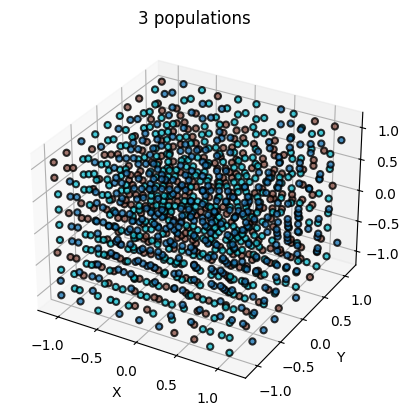

Metadata for graph_id 0 node_id  0 successfully constructed.


In [65]:
node = Node(parameters=node_parameters)
node.build()

In [66]:
def generate_node_parameters_list(n_nodes=5, 
                                   n_types=5, 
                                   vary_polynoms=True,
                                   vary_types_per_node=True,
                                   safe_mode=True,      
                                   max_power=2,
                                   max_coeff=0.8,
                                 graph_id=0):      
    """
    Generiert Parameter-Liste für Nodes mit optionalem Safe Mode
    
    Args:
        n_nodes: Anzahl Nodes
        n_types: Anzahl Types pro Node
        vary_polynoms: Ob Polynome variiert werden
        vary_types_per_node: Ob Type-Anzahl variiert
        safe_mode: Verhindert Overflow in Polynomen
        max_power: Maximale Potenz (0-2 empfohlen)
        max_coeff: Maximaler Koeffizient
    """
    params_list = []
    
    for i in range(n_nodes):
        if vary_types_per_node:
            node_n_types = np.random.randint(1, n_types + 1)
        else:
            node_n_types = n_types
        
        types = list(range(node_n_types))
        
        available_models = ["iaf_psc_alpha", "iaf_psc_exp", "iaf_psc_delta"]
        neuron_models = [available_models[i % len(available_models)] 
                        for i in range(node_n_types)]
        
        probability_vector = list(np.random.dirichlet([1] * node_n_types))
        
        params = {
            "types": types,
            "neuron_models": neuron_models,
            "grid_size": [
                np.random.randint(8, 15),
                np.random.randint(8, 15),
                np.random.randint(8, 15)
            ],
            "m": [
                np.random.uniform(-1.0, 1.0),
                np.random.uniform(-1.0, 1.0),
                np.random.uniform(-1.0, 1.0)
            ],
            "rot_theta": np.random.uniform(-np.pi, np.pi),
            "rot_phi": np.random.uniform(-np.pi, np.pi),
            "transform_matrix": [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
            "dt": np.random.uniform(0.005, 0.02),
            "old": True,
            "num_steps": np.random.randint(5, 12),
            "plot_clusters": False,
            "title": f"Node_{i}",
            "sparse_holes": np.random.randint(0, 3),
            "sparsity_factor": np.random.uniform(0.85, 0.95),
            "probability_vector": probability_vector,
            "name": f"Node_{i}",
            "id": i,
            "graph_id":graph_id,
            "distribution": [],
            "conn_prob": [],
            "polynom_max_power": 5,
            "coefficients": None,
            "center_of_mass": np.array([0.0, 0.0, 0.0]),
            "displacement": np.array([0.0, 0.0, 0.0]),
            "displacement_factor": 1.0,
            "field": None,
        }
        
        if vary_polynoms:
            encoded_polynoms = []
            
            for type_idx in range(node_n_types): 
                type_polynoms = []
                
                for coord in range(3):  # x, y, z
                    num_terms = np.random.randint(2, 5)  # Weniger Terms
                    
                    indices = []
                    coeffs = []
                    
                    for _ in range(num_terms):
                        idx = np.random.choice([0, 1, 2])
                        
                        if safe_mode:
                            # Safe: kleinere Powers und Koeffizienten
                            power = np.random.choice(range(min(max_power + 1, 4)))
                            coeff = np.random.uniform(-max_coeff, max_coeff)
                        else:
                            # Original: kann overflow verursachen
                            power = np.random.choice([0, 1, 2, 3])
                            coeff = np.random.randn() * 0.5
                        
                        indices.append([idx, power])
                        coeffs.append(float(coeff))
                    
                    poly_encoded = {
                        'indices': indices,
                        'coefficients': coeffs,
                        'n': 5,
                        'decay': 0.5
                    }
                    type_polynoms.append(poly_encoded)
                
                encoded_polynoms.append(type_polynoms)
            
            params["encoded_polynoms_per_type"] = encoded_polynoms
        else:
            # Identity polynoms
            identity_polynoms = []
            for type_idx in range(node_n_types):
                type_polynoms = [
                    {'indices': [[0, 1]], 'coefficients': [1.0], 'n': 5, 'decay': 0.5},
                    {'indices': [[1, 1]], 'coefficients': [1.0], 'n': 5, 'decay': 0.5},
                    {'indices': [[2, 1]], 'coefficients': [1.0], 'n': 5, 'decay': 0.5}
                ]
                identity_polynoms.append(type_polynoms)
            
            params["encoded_polynoms_per_type"] = identity_polynoms
        
        params_list.append(params)
    
    return params_list

In [67]:
generate_node_parameters_list()############################################################

[{'types': [0, 1],
  'neuron_models': ['iaf_psc_alpha', 'iaf_psc_exp'],
  'grid_size': [13, 9, 9],
  'm': [0.5836962112154065, 0.9005066362250906, 0.8565427832366503],
  'rot_theta': -0.4695199239427055,
  'rot_phi': -0.3287108310062199,
  'transform_matrix': [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
  'dt': 0.005196248362706331,
  'old': True,
  'num_steps': 6,
  'plot_clusters': False,
  'title': 'Node_0',
  'sparse_holes': 2,
  'sparsity_factor': 0.8864172997145299,
  'probability_vector': [np.float64(0.41784600761753626),
   np.float64(0.5821539923824637)],
  'name': 'Node_0',
  'id': 0,
  'graph_id': 0,
  'distribution': [],
  'conn_prob': [],
  'polynom_max_power': 5,
  'coefficients': None,
  'center_of_mass': array([0., 0., 0.]),
  'displacement': array([0., 0., 0.]),
  'displacement_factor': 1.0,
  'field': None,
  'encoded_polynoms_per_type': [[{'indices': [[np.int64(1), np.int64(0)],
      [np.int64(1), np.int64(0)]],
     'coefficients': [0.29772785982661776, -0.08428094874568204]

# GRAPH CLASS

In [68]:
class Graph:
    def __init__(self,
                 graph_name="",
                 graph_id=0,
                 parameter_list=[],
                 polynom_max_power=5,
                 polynom_decay=0.8,
                 position=None,
                max_nodes=None):

        self.node_list = []
        self.node_dict = {}
        self.graph_id=graph_id
        self.nodes = 0
        self.graph_name=graph_name
        self._next_id = 0
        self.max_nodes=max_nodes if max_nodes else len(parameter_list)
        
        # Init Position
        if position is not None:
            self.init_position = np.array(position)
        elif parameter_list and len(parameter_list) > 0:
            self.init_position = np.array(parameter_list[0].get("m", [0.0, 0.0, 0.0]))
        else:
            self.init_position = np.array([0.0, 0.0, 0.0])
        
        self.parameter_list = parameter_list if parameter_list else []
        self.polynom_max_power = polynom_max_power
        self.polynom_decay = polynom_decay
        self.polynom_generator = PolynomGenerator(n=polynom_max_power, decay=polynom_decay)
        
        self.root = None
    
    def random_direction(self, length=1.0):
        v = np.random.randn(3)
        v = v / np.linalg.norm(v)
        return v * length
    
    def create_node(self, 
                    parameters=None,
                    other=None,
                    is_root=False,
                    displacement=None,
                    displacement_factor=1.0,
                    auto_build=False):
        node_id = self._next_id
        
        if parameters:
            params = parameters.copy()
        else:
            params = {}
        
        params['id'] = node_id
        if 'name' not in params or params.get('name', '').startswith('Node_'):
            params['name'] = f"Node_{node_id}"
        
        if other is not None:
            if displacement is None:
                displacement = self.random_direction(displacement_factor)
            new_position = np.array(other.center_of_mass) + displacement
            params['m'] = new_position.tolist()
        elif not is_root and 'm' not in params:
            params['m'] = [0.0, 0.0, 0.0]
        
        if is_root or other is None:
            function_generator = self.polynom_generator
        else:
            function_generator = None
        
        new_node = Node(
            function_generator=function_generator,
            parameters=params,
            other=other
        )
        new_node.build()
        
        new_node.id = node_id
        new_node.name = params['name']
        
        self.node_dict[new_node.name] = new_node
        self.node_dict[new_node.id] = new_node
        
        self._next_id += 1
        self.node_list.append(new_node)
        self.nodes += 1
        if self.root is None:
            self.root = new_node
        
        if auto_build:
            try:
                new_node.build()
            except Exception as e:
                print(f"⚠ Build failed for Node {node_id}: {e}")
        
        return new_node
    def populate(self,
                 n_iterations=5,
                 displacement_function=None,
                 displacement_factor=1.0,
                 parameters_dict=None,
                 parameters_list=None,
                 node_names=None,
                 random_parent=True,
                 mutation=False,
                 auto_build=False):
        
        if displacement_function is None:
            displacement_function = self.random_direction
        
        if parameters_dict is None:
            if parameters_list is not None:
                parameters_dict = {i: params for i, params in enumerate(parameters_list)}
            elif self.parameter_list:
                parameters_dict = {i: params for i, params in enumerate(self.parameter_list)}
            else:
                raise ValueError("No parameters available")
        
        if node_names is None:
            node_names = {}
        
        # Create root
        root_params = parameters_dict.get(0, list(parameters_dict.values())[0])
        root_params['name'] = node_names.get(0, "Root")
        root_params['m'] = self.init_position.tolist()
        
        self.root = self.create_node(
            parameters=root_params,
            is_root=True,
            auto_build=auto_build
        )
        
        # Populate iterations
        for iteration in range(n_iterations):
            current_nodes = self.node_list.copy()
            n_current = len(current_nodes)
            
            if random_parent:
                p = rand_prob_vector(n_current)
            else:
                p = None
            
            created_count = 0
            
            for node in current_nodes:
                if self.nodes >= self.max_nodes:
                    break
                
                next_id = self._next_id
                
                if next_id not in parameters_dict:
                    if mutation and node.parent is not None:
                        node_params = node.parent.parameters.copy()
                    else:
                        continue
                else:
                    node_params = parameters_dict[next_id]
                
                parent = np.random.choice(current_nodes, p=p) if random_parent else node
                
                node_params['name'] = node_names.get(next_id, f"Node_{next_id}")
                
                new_node = self.create_node(
                    parameters=node_params,
                    other=parent,
                    displacement=displacement_function(displacement_factor),
                    auto_build=auto_build
                )
                
                if mutation and new_node.parent is not None:
                    new_node.coefficients = new_node.update_coefficients(
                        coefficients=new_node.parent.coefficients
                    )
                    new_node.function_generator.coefficients = new_node.coefficients
                
                created_count += 1
            
            if created_count == 0 or self.nodes >= self.max_nodes:
                break



                
    def build_all(self):
        for i, node in enumerate(self.node_list, 1):
            try:
                node.build()
                node.already_built = False
            except Exception as e:
                print(f"✗ Error: {e}")
    
    def get_node(self, identifier):
        if isinstance(identifier, int):
            identifier = identifier
        return self.node_dict.get(identifier)
    
    def remove_node(self, node):
        if node in self.node_list:
            node.remove()
            self.node_list.remove(node)
            
            if node.name in self.node_dict:
                del self.node_dict[node.name]
            if str(node.id) in self.node_dict:
                del self.node_dict[str(node.id)]
            
            self.nodes -= 1
            print(f"Node {node.id} ({node.name}) deleted")
        else:
            print(f"No node with id {node.id} found")
    
    def connect_nodes(self, from_node, to_node):
        from_node.add_edge_to(to_node)
    
    def list_nodes(self):
        print(f"{'ID':<4} {'Name':<15} {'Position':<25} {'Parent':<10} {'Children':<10}")
        print("-" * 75)
        for node in self.node_list:
            pos_str = f"({node.center_of_mass[0]:.2f}, {node.center_of_mass[1]:.2f}, {node.center_of_mass[2]:.2f})"
            parent_str = f"{node.parent.id}" if node.parent else "None"
            children_str = f"{len(node.next)}"
            pop_str = f", Pop: {len(node.population)}" if node.population else ""
            print(f"{node.id:<4} {node.name:<15} {pos_str:<25} {parent_str:<10} {children_str:<10}{pop_str}")
    

    

    def __repr__(self):
        return f"Graph(nodes={self.nodes}, edges={sum(len(n.next) for n in self.node_list)})"


In [69]:
def createGraph(parameter_list=None, max_nodes=10, graph_id=0):
    parameter_list = parameter_list if parameter_list is not None else generate_node_parameters_list(n_nodes=max_nodes, n_types=3, graph_id=graph_id)
    max_nodes = len(parameter_list)
    graph = Graph(parameter_list=parameter_list, graph_id=graph_id)  # <-- graph_id hinzugefügt!
    graph.populate()
    return graph

def graphInfo(graph, figsize_per_plot=(5, 4), marker_size=10, alpha=0.6, linewidths=0.5):
    n_nodes = len(graph.node_list)
    if n_nodes == 0:
        return
    plot_graph_3d(graph)
    # Grid-Layout berechnen
    n_cols = int(np.ceil(np.sqrt(n_nodes)))
    n_rows = int(np.ceil(n_nodes / n_cols))
    
    fig = plt.figure(figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows))
    
    for idx, node in enumerate(graph.node_list):
        ax = fig.add_subplot(n_rows, n_cols, idx + 1, projection='3d')
        
        # Cluster plotten
        clusters = node.positions
        n_types = len(clusters)
        cmap_obj = plt.get_cmap('tab10')
        colors = [cmap_obj(i / max(n_types - 1, 1)) for i in range(n_types)]
        
        for pts, col in zip(clusters, colors):
            pts = np.asarray(pts)
            if pts.size > 0:
                ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                          c=[col], s=marker_size, 
                          edgecolor='k', alpha=alpha, linewidths=linewidths)
        
        # Titel mit Node-Info
        type_info = f"Types: {node.types}" if len(node.types) <= 5 else f"Types: {len(node.types)}"
        ax.set_title(f"{node.name}\n{type_info}", fontsize=10)
        
        ax.set_xlabel('X', fontsize=8)
        ax.set_ylabel('Y', fontsize=8)
        ax.set_zlabel('Z', fontsize=8)
        ax.tick_params(labelsize=7)
    
    # Leere subplots ausblenden
    for idx in range(n_nodes, n_rows * n_cols):
        fig.add_subplot(n_rows, n_cols, idx + 1).axis('off')
    
    plt.tight_layout()
    plt.show()
    pos = []


    for node in graph.node_list:
        for x in node.positions:
            pos.append(x)
    plot_point_clusters(pos)

In [70]:
graph = createGraph()

Metadata for graph_id 0 node_id  0 successfully constructed.
Metadata for graph_id 0 node_id  1 successfully constructed.
Metadata for graph_id 0 node_id  2 successfully constructed.
Metadata for graph_id 0 node_id  3 successfully constructed.
Metadata for graph_id 0 node_id  4 successfully constructed.
Metadata for graph_id 0 node_id  5 successfully constructed.
Metadata for graph_id 0 node_id  6 successfully constructed.
Metadata for graph_id 0 node_id  7 successfully constructed.
Metadata for graph_id 0 node_id  8 successfully constructed.
Metadata for graph_id 0 node_id  9 successfully constructed.


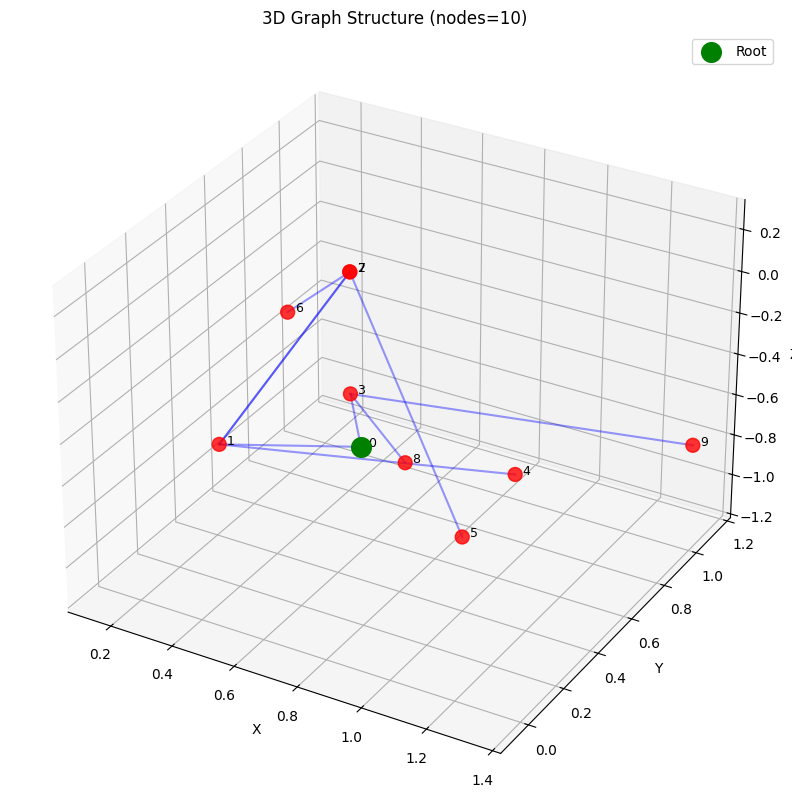

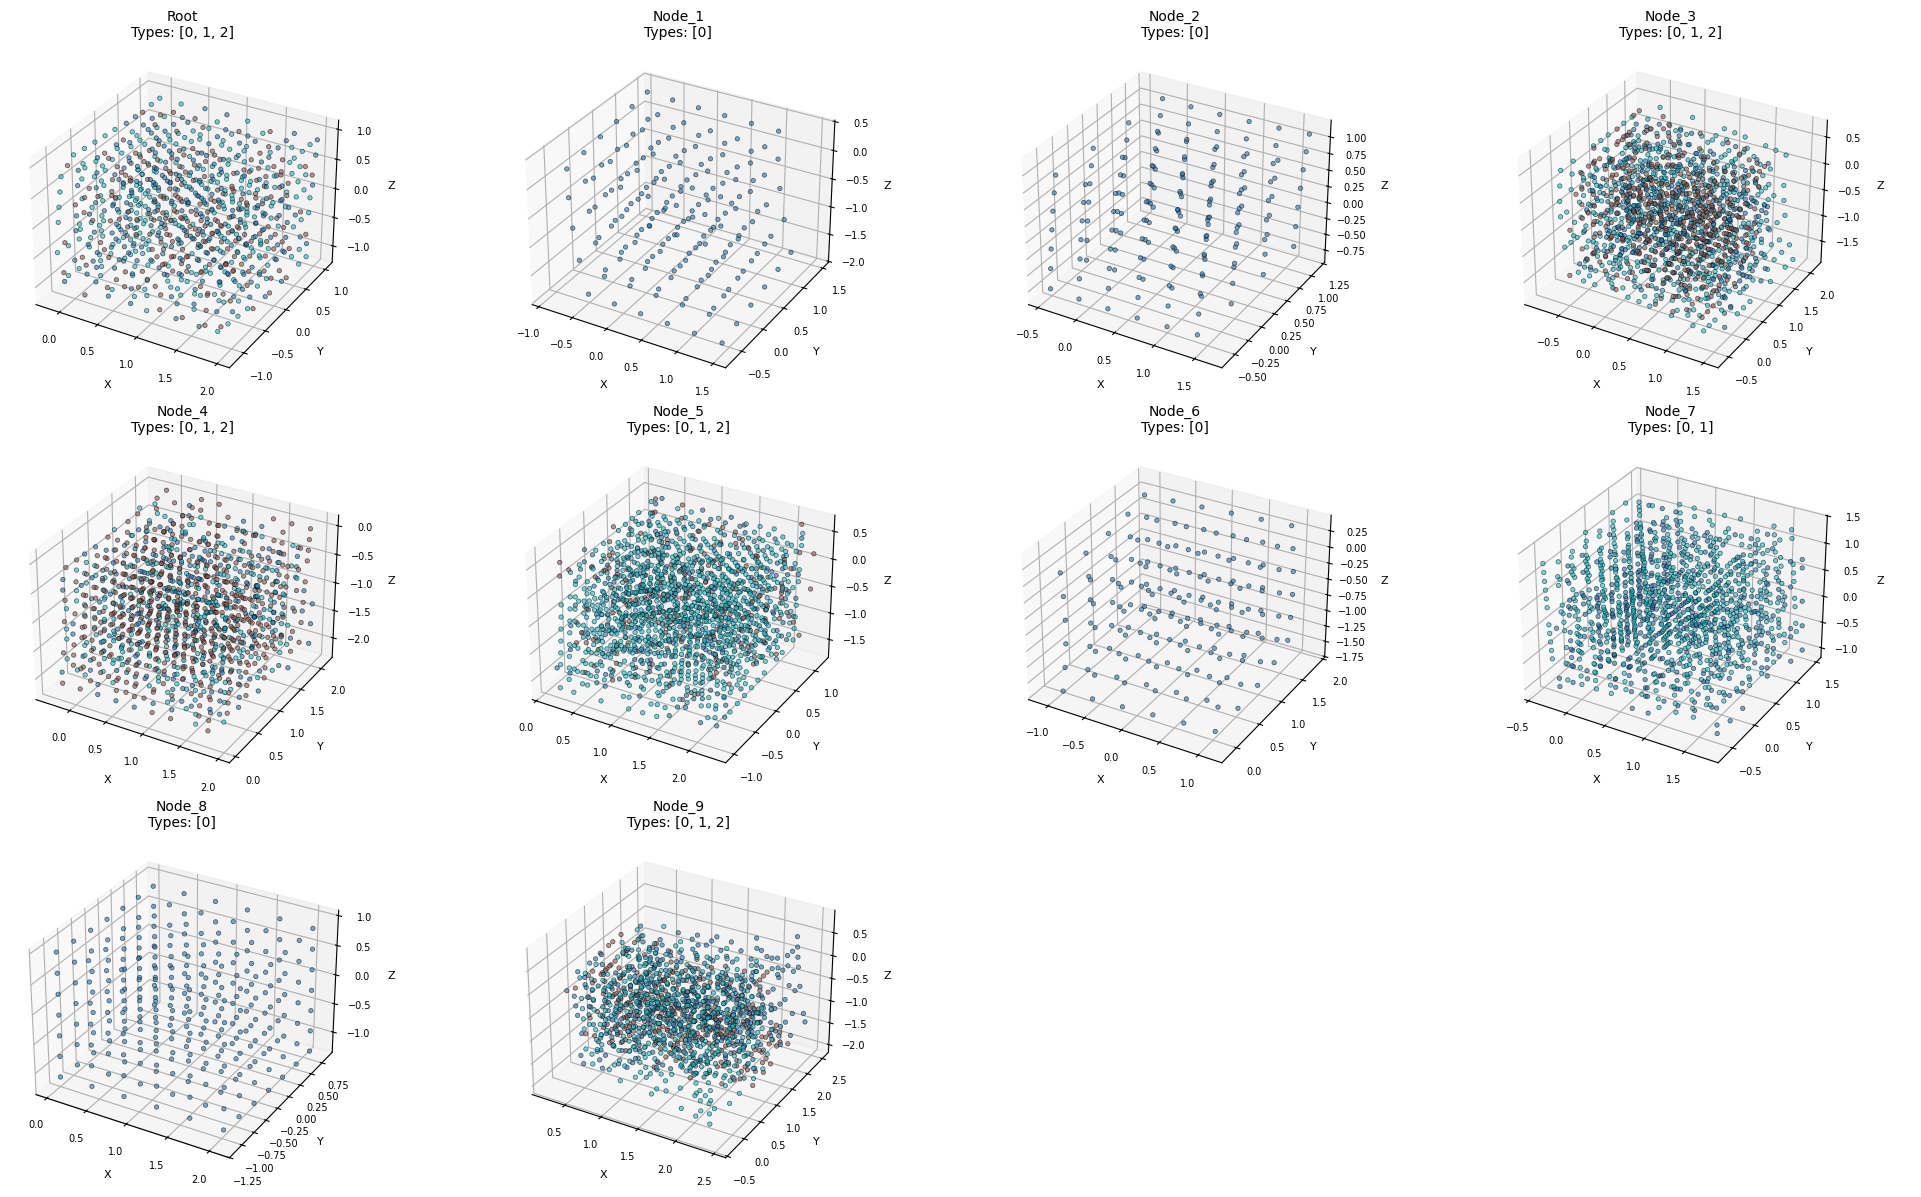

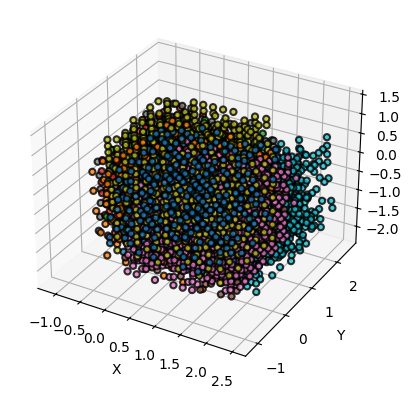

In [71]:
graphInfo(graph)